# Setup

In [1]:
import getpass
import numpy as np
import matplotlib.pyplot as plt

import axs
import pyspark.sql.functions as sparkfunc

import dipper

In [2]:
%matplotlib notebook

In [3]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[20]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
    )   

    return spark

username = getpass.getuser()
spark_session = spark_start(f"/epyc/users/{username}/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [4]:
spark_session

# Select the best dippers

In [5]:
# Load a catalog where we have used loose selection cuts
# to find dippers and measured lots of different dip properties.
# This has 4.5M lightcurves.
wtf = catalog.load('wtf_march2020_full_3')

In [6]:
# Select the good dippers with a set of cuts tuned to
# pull out what we are looking for.
cut_wtf = (
    wtf
    .where(
        (sparkfunc.col("dip.significance") >= 5)
        & (sparkfunc.col("dip.significant_observation_count") >= 3)
        
        & (sparkfunc.col("dip.max_gap_fraction") < 0.8)
        
        & (sparkfunc.col("dip.core_length") >= 0.5)
        & (sparkfunc.col("dip.core_not_significant_fraction") < 0.2)
        & (sparkfunc.col("dip.core_significant_count") > 3.)

        & (sparkfunc.col("dip.ref_pull_std") < 2.)
        & (sparkfunc.col("dip.ref_length_fraction_before") > 0.5)
        & (sparkfunc.col("dip.ref_length_fraction_after") > 0.5)
    )
)
best_dippers = cut_wtf.sort(cut_wtf['dip.significance'].desc()).head(1000)

In [7]:
cut_wtf.count()

63249

In [10]:
%matplotlib inline

In [12]:
wtf.count()

7928199

/astro/users/kyboone/boyajian/ZTF_Boyajian/dipper.py:965: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 6), dpi=100)


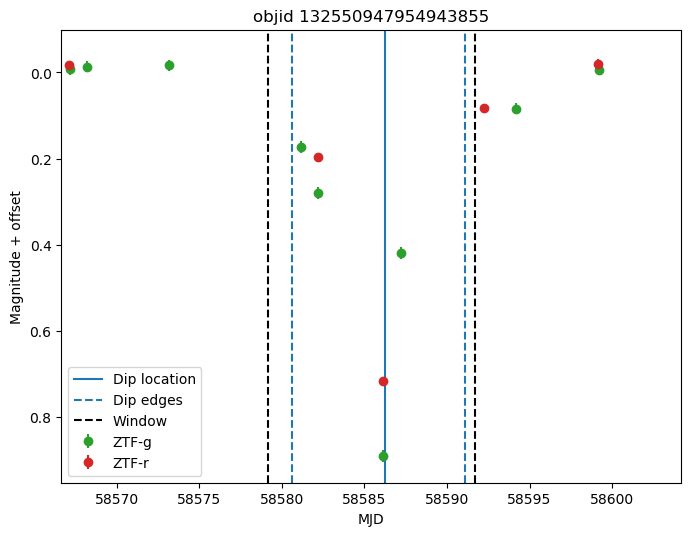

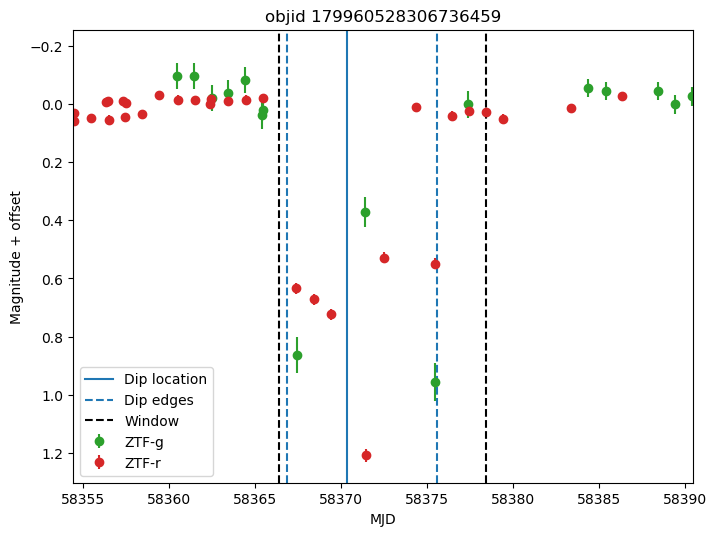

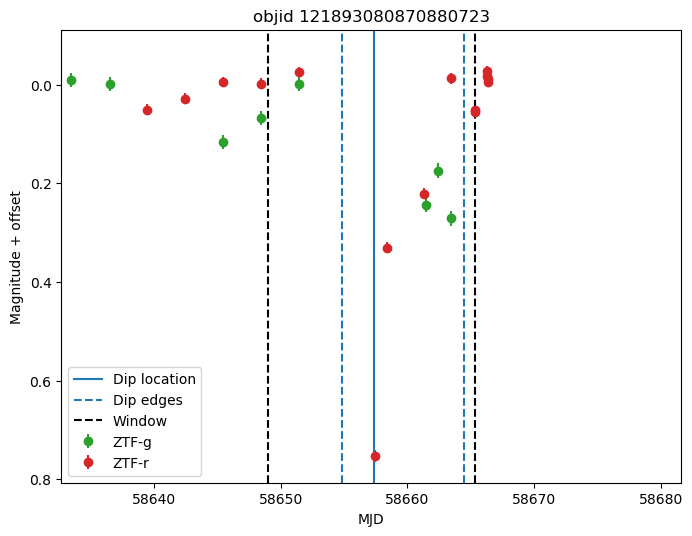

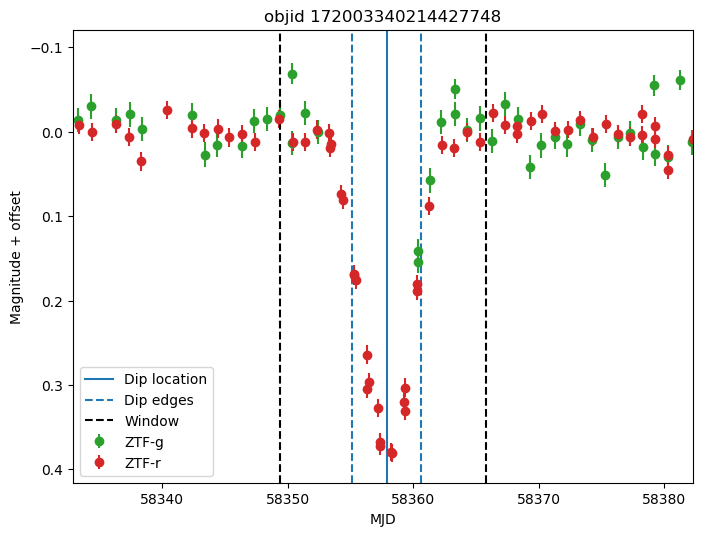

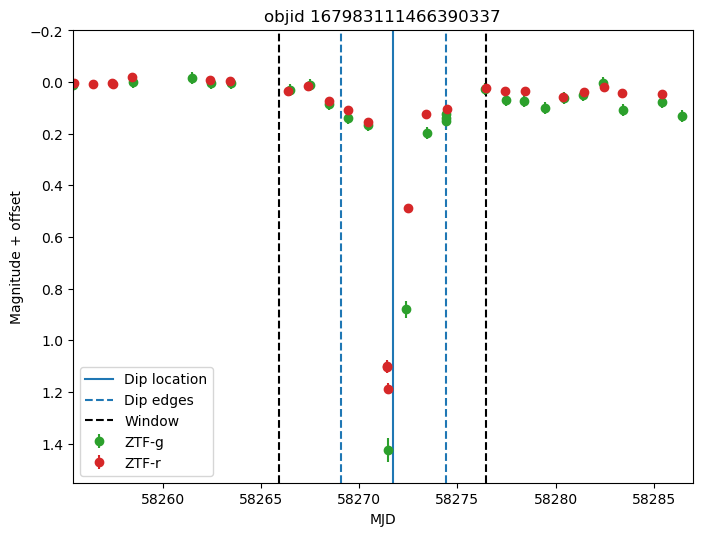

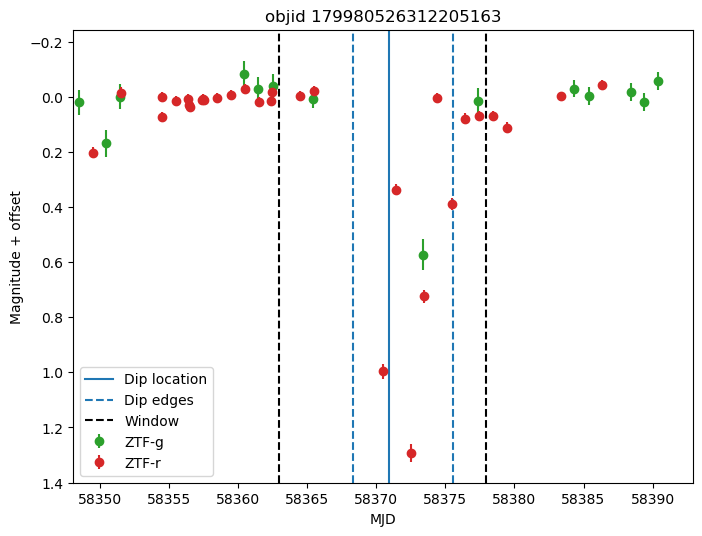

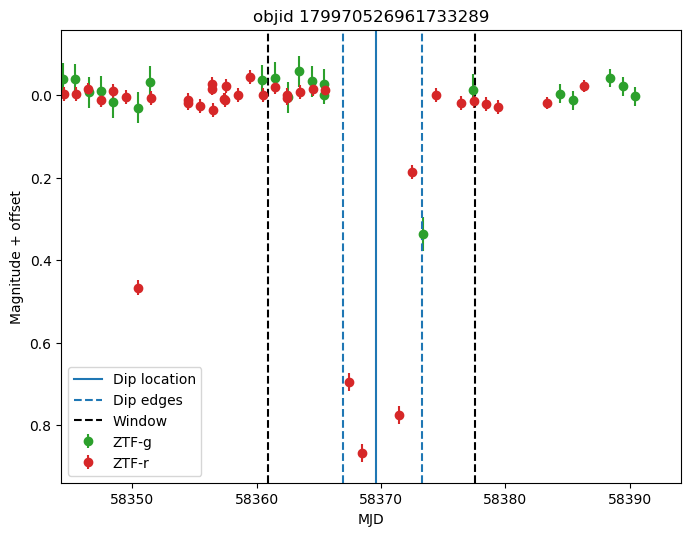

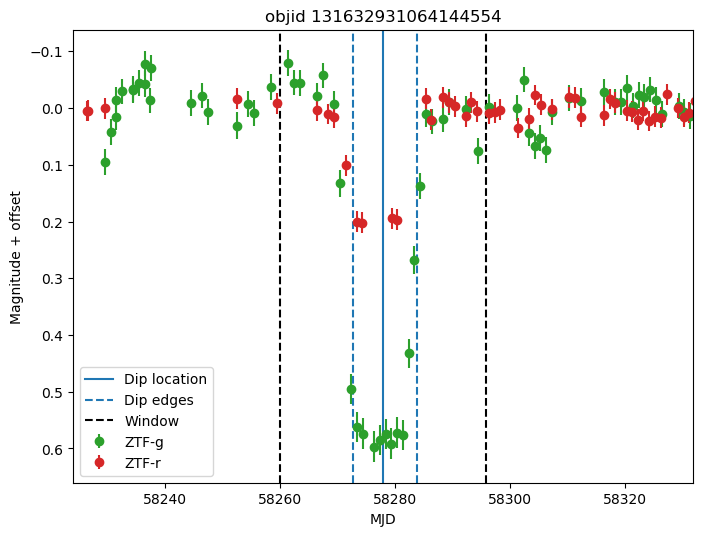

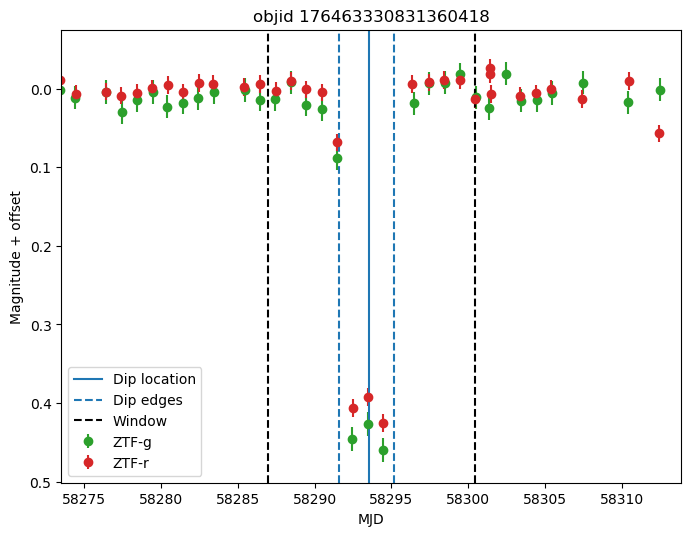

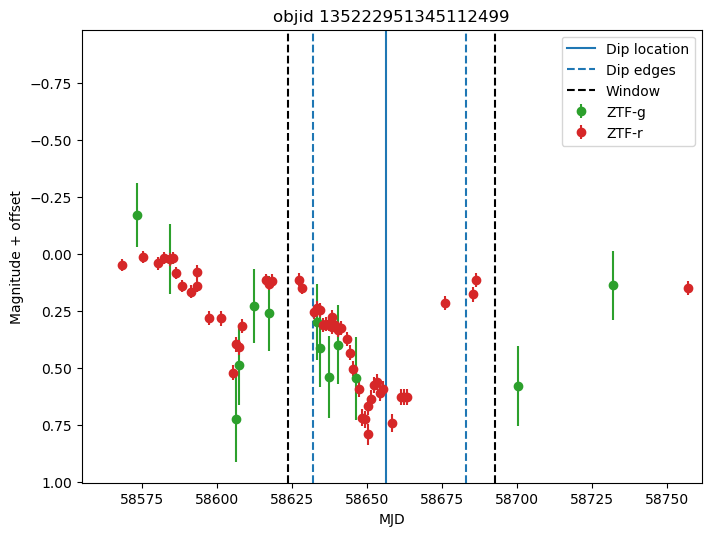

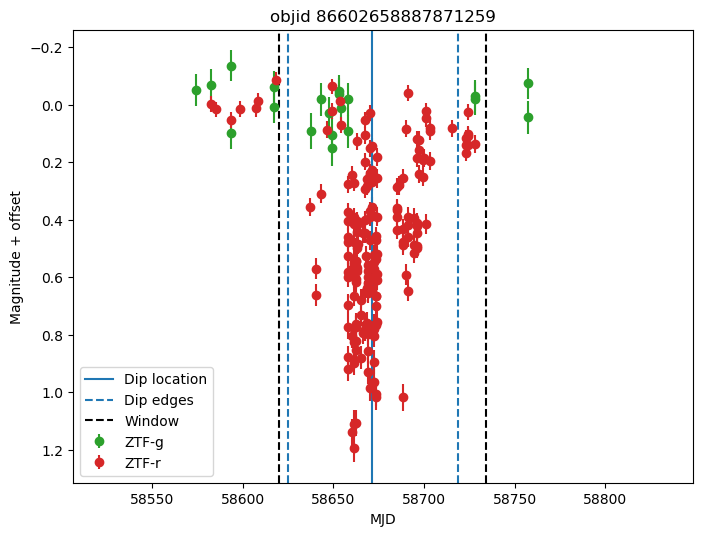

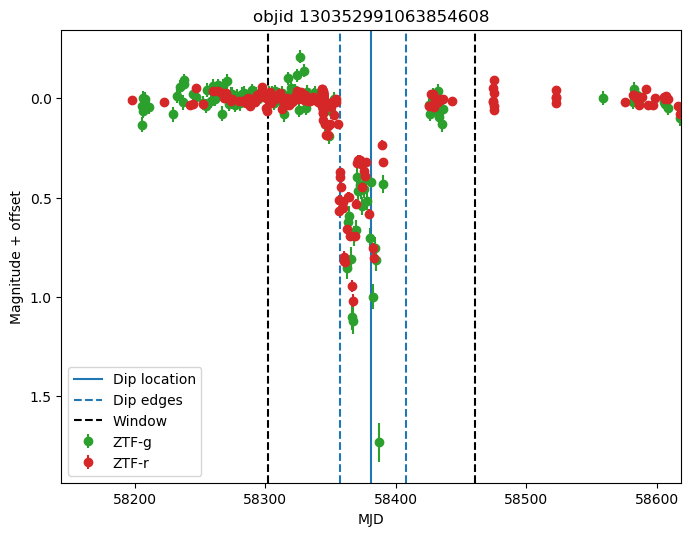

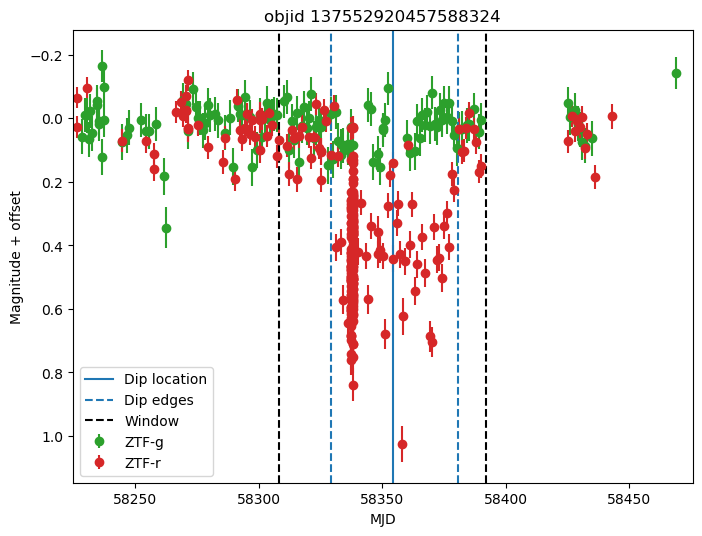

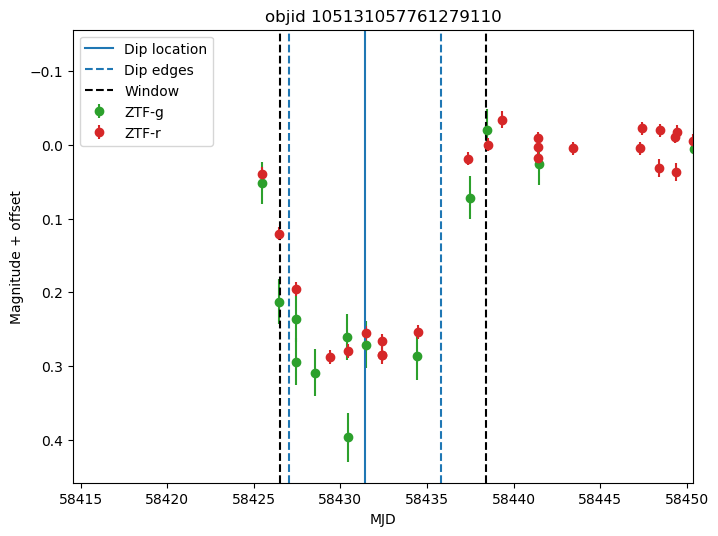

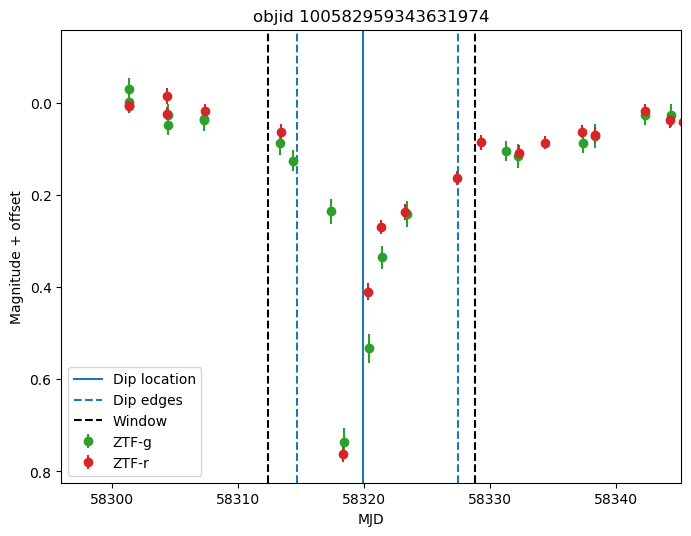

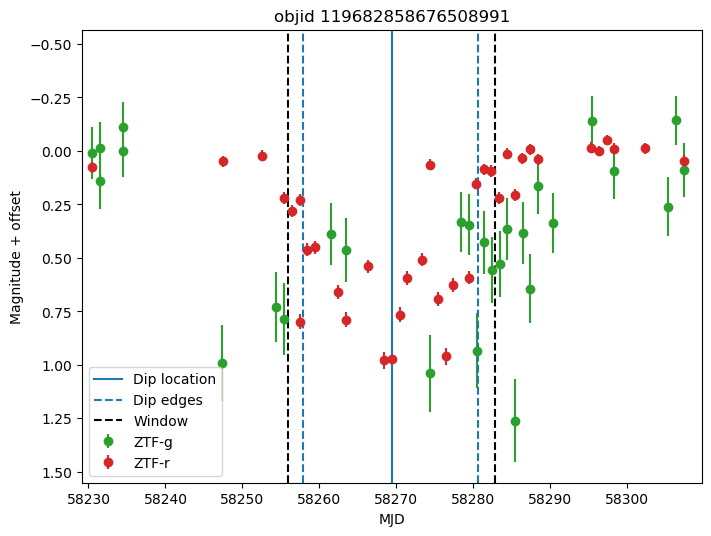

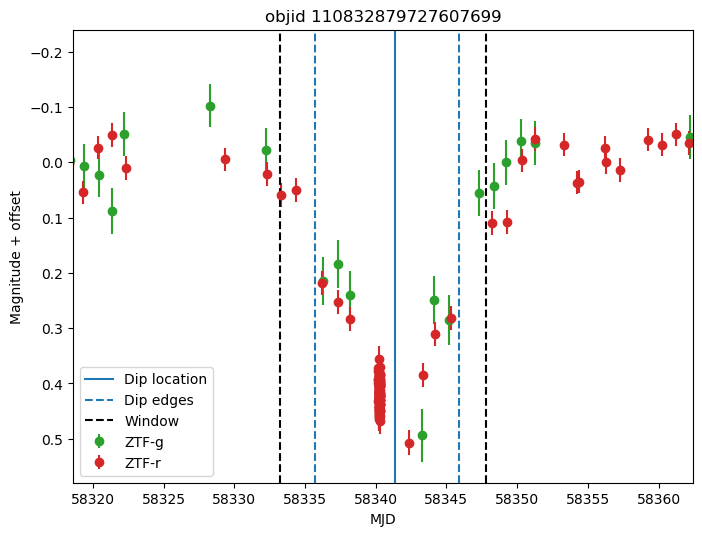

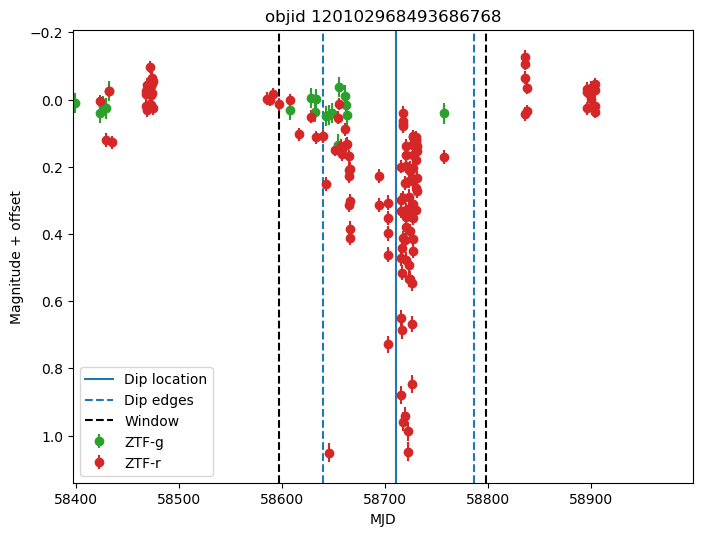

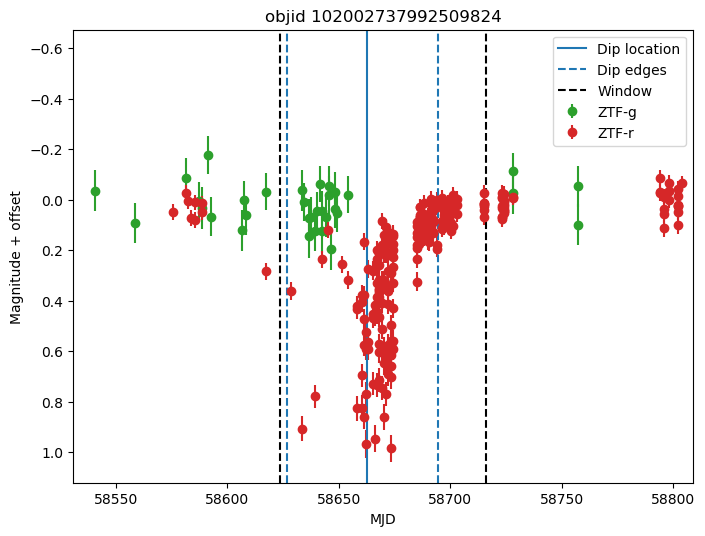

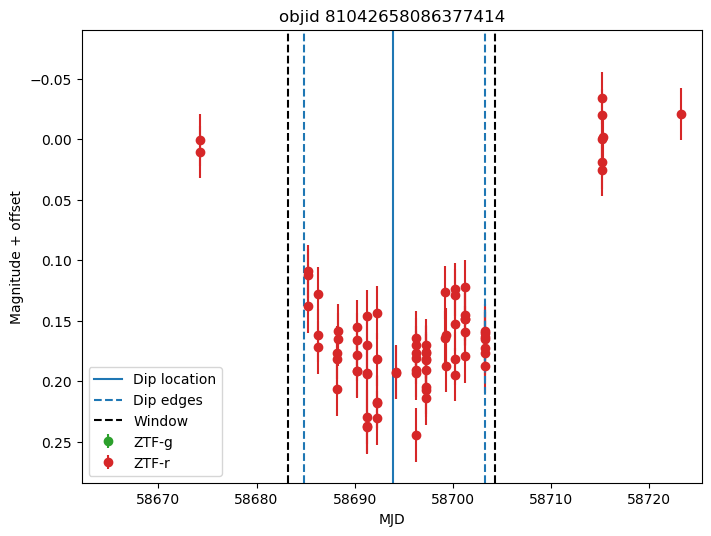

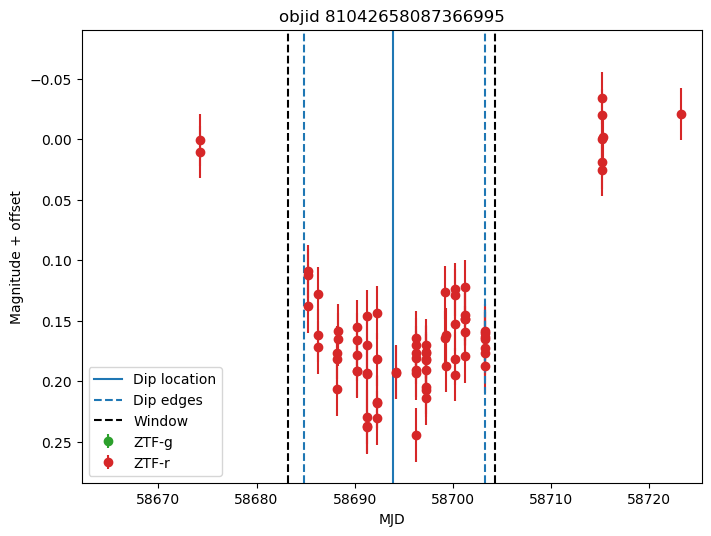

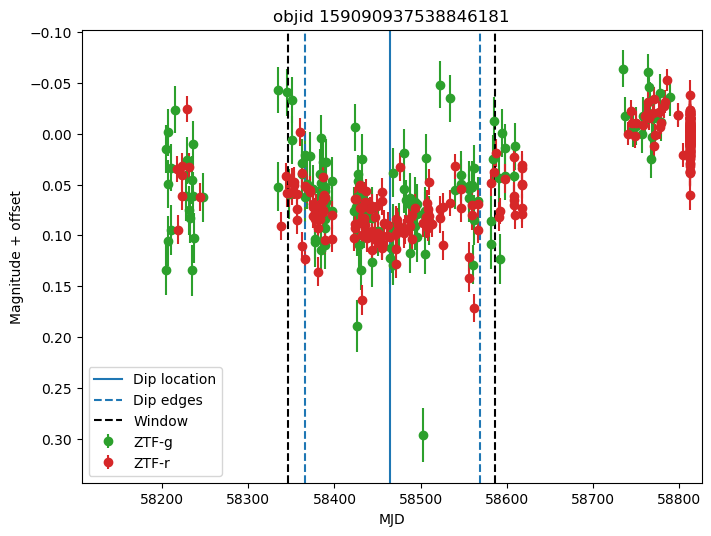

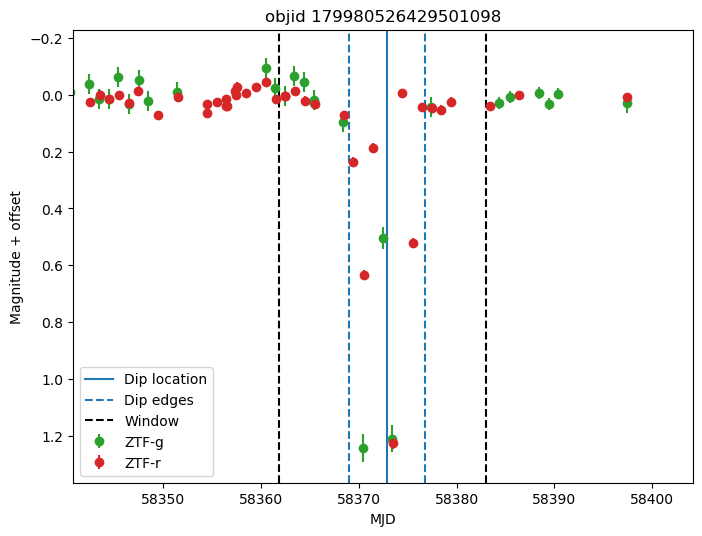

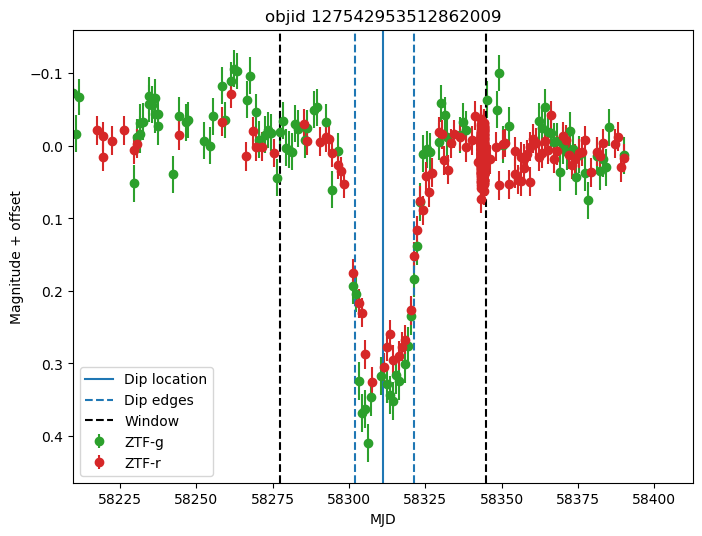

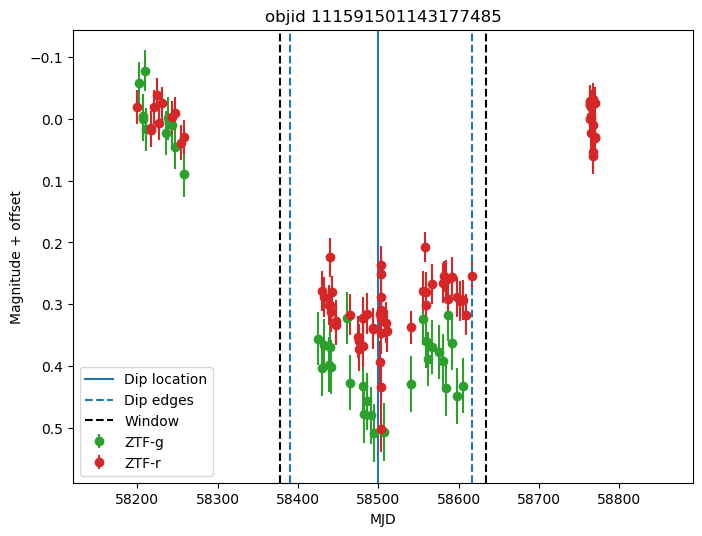

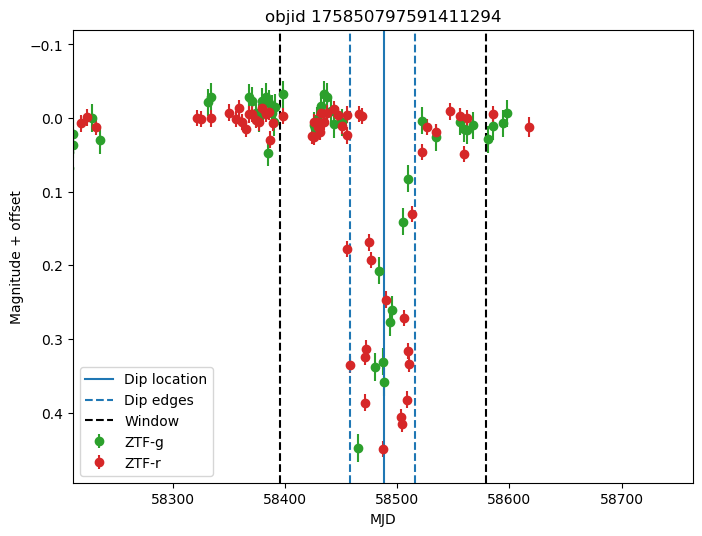

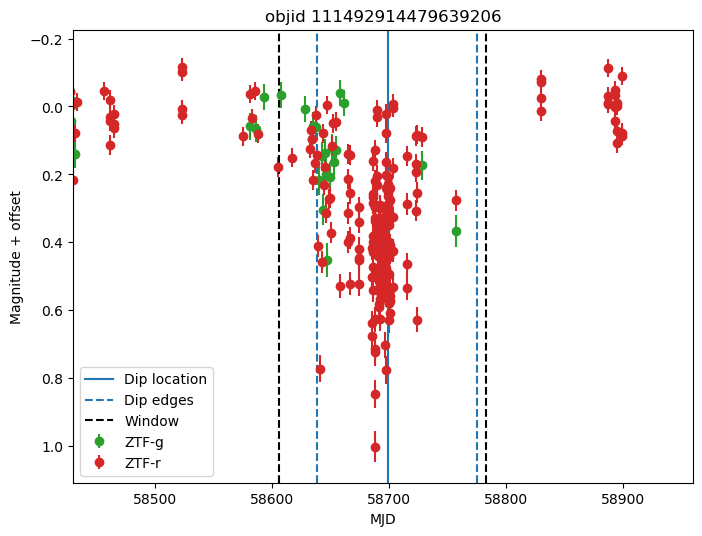

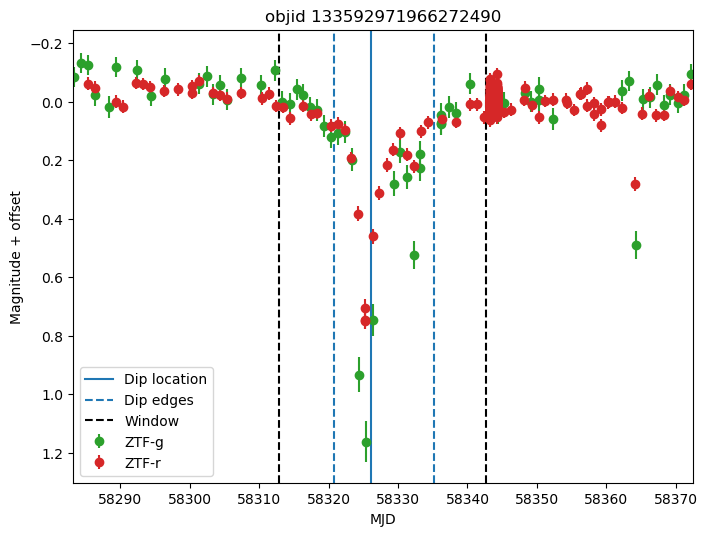

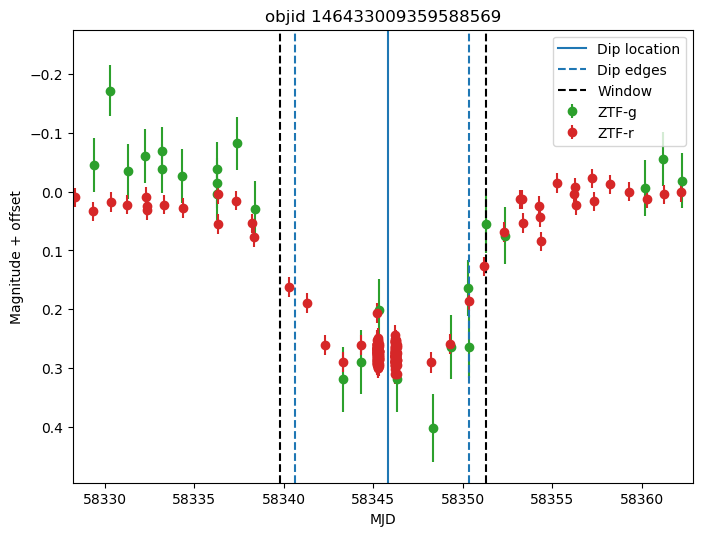

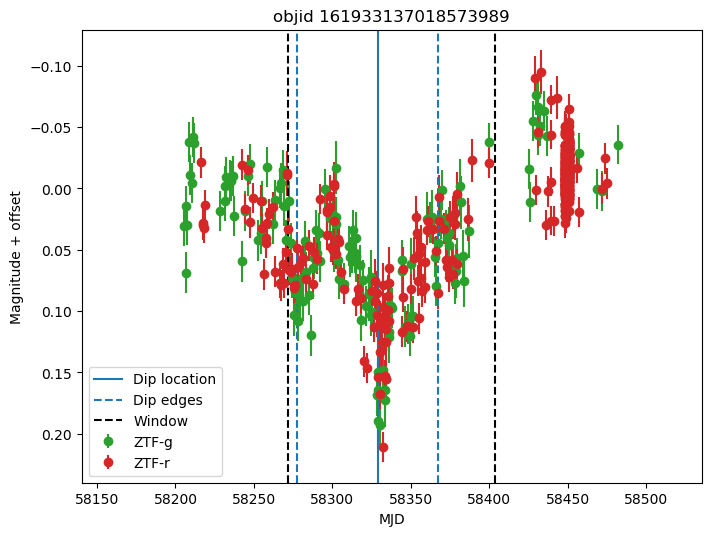

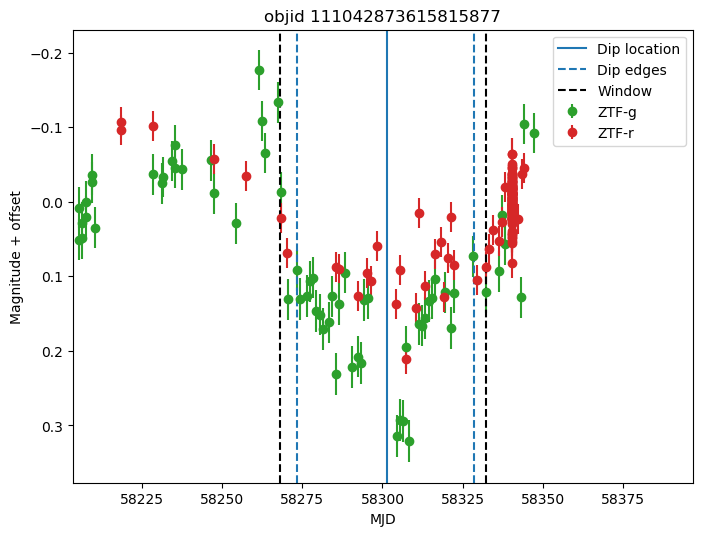

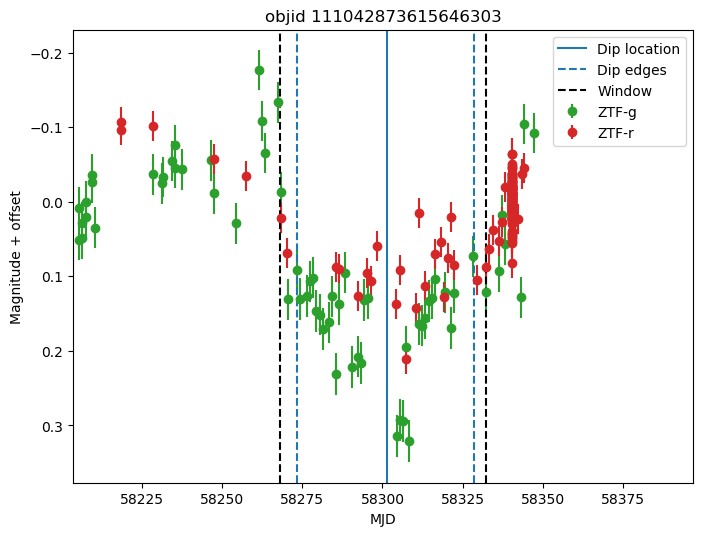

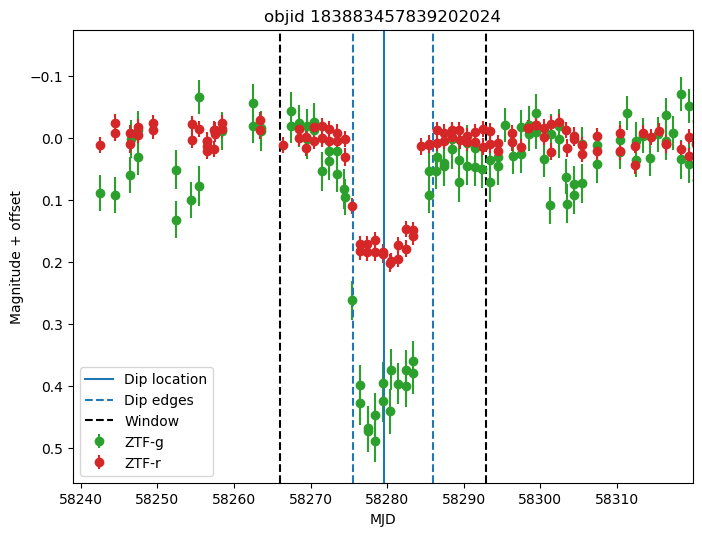

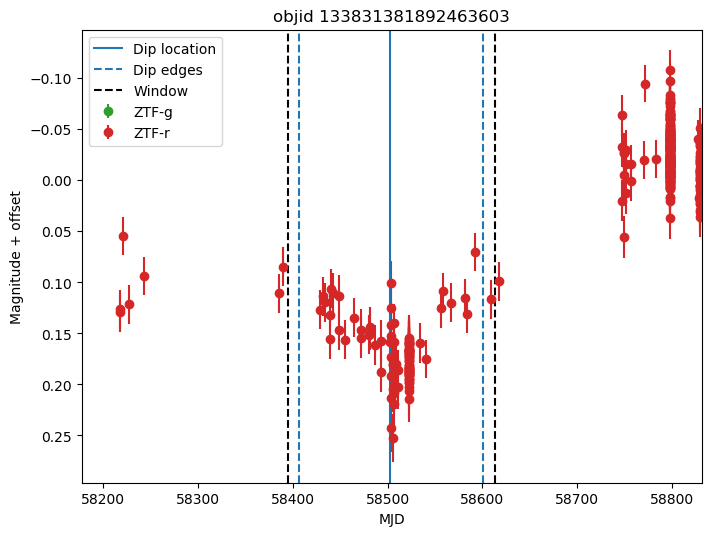

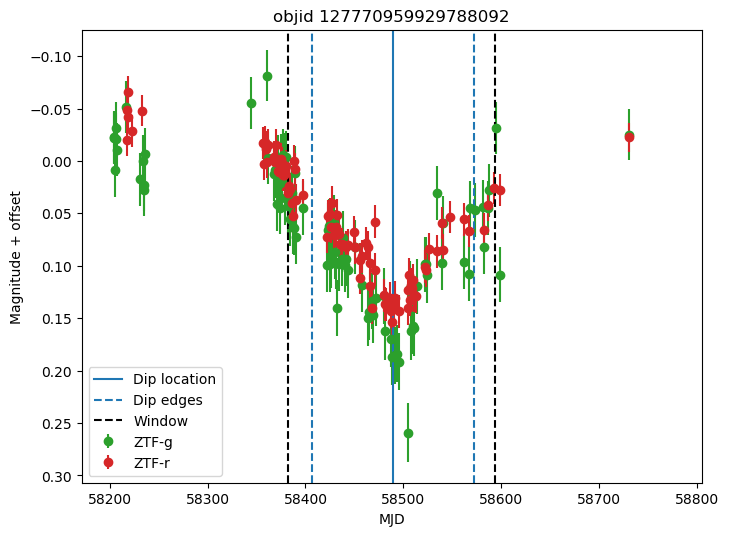

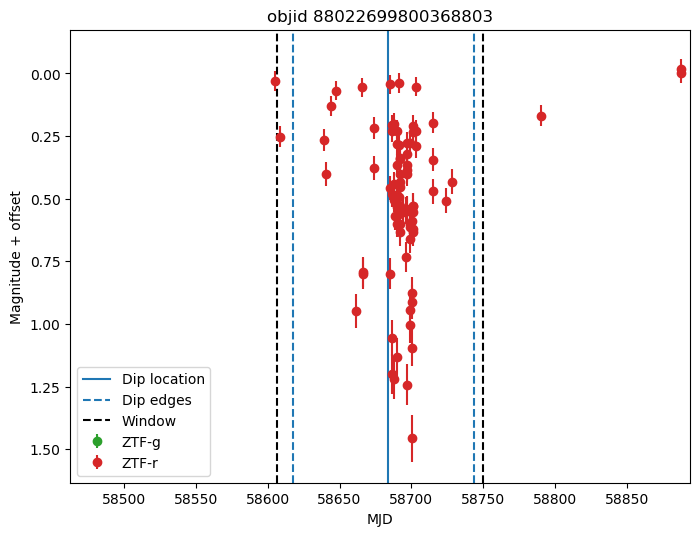

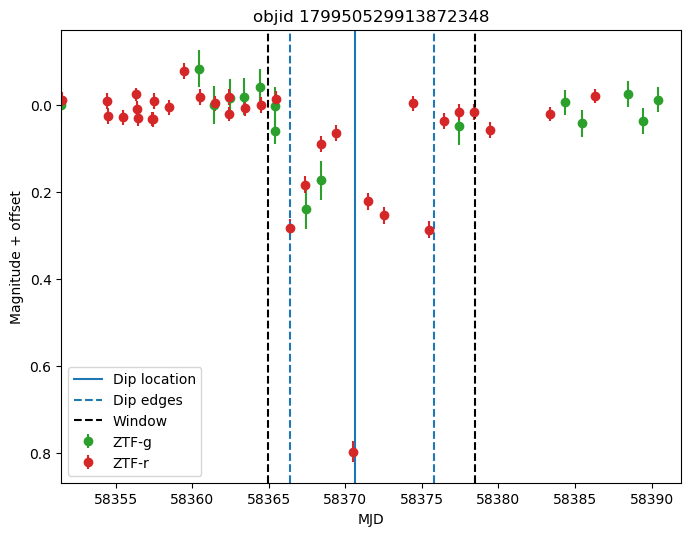

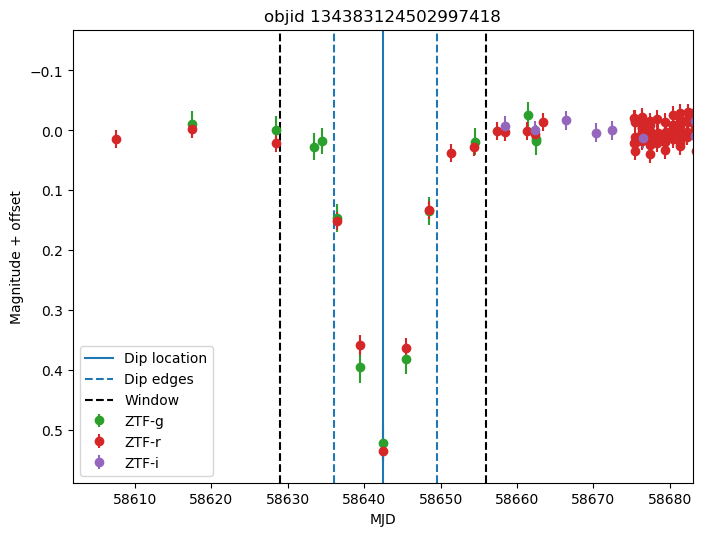

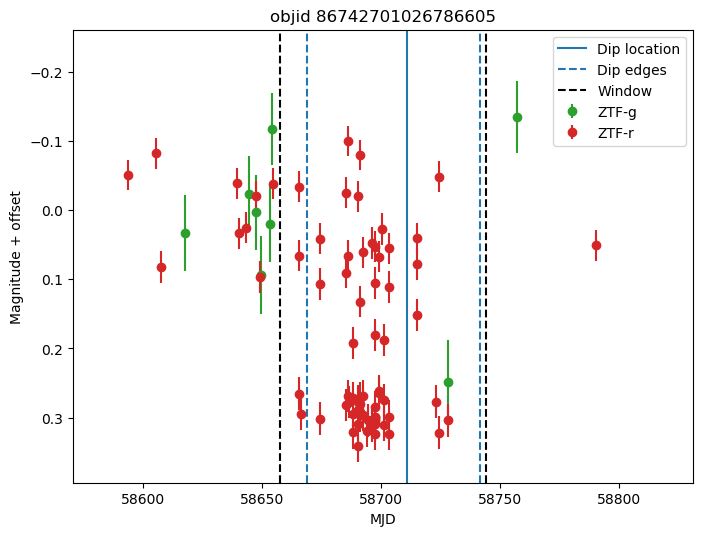

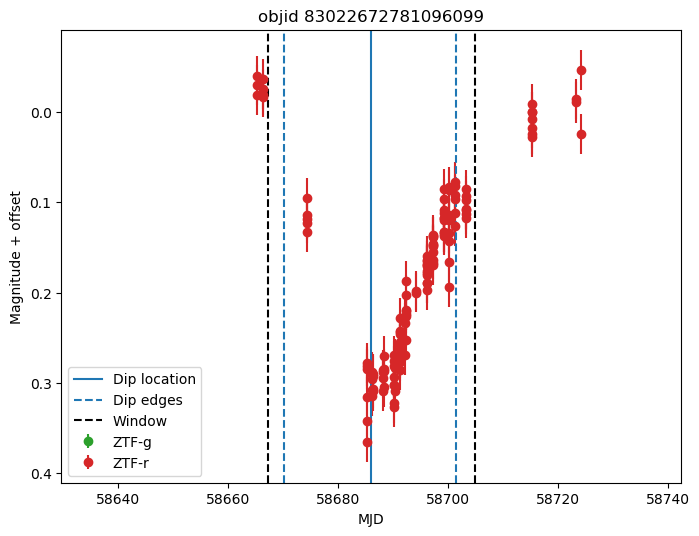

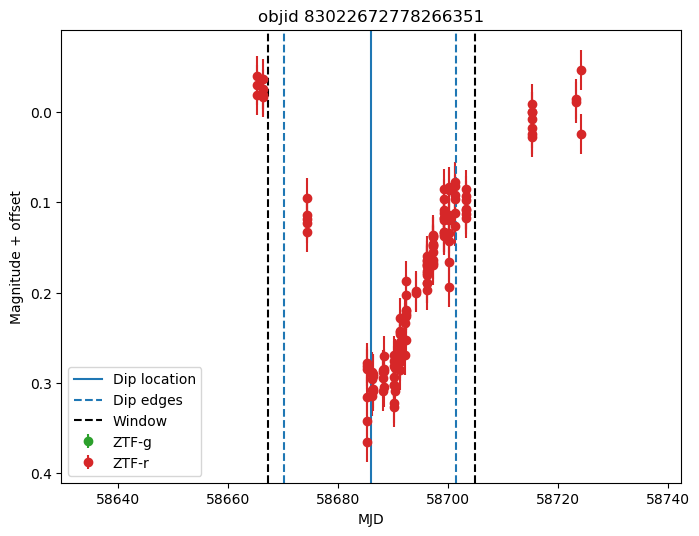

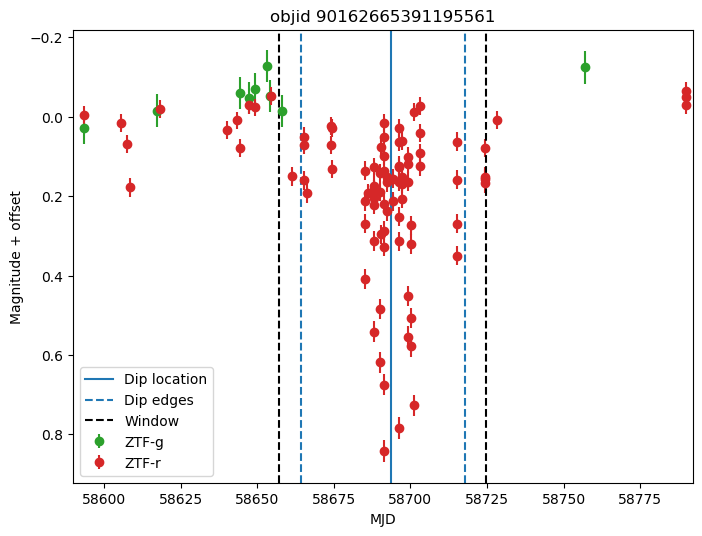

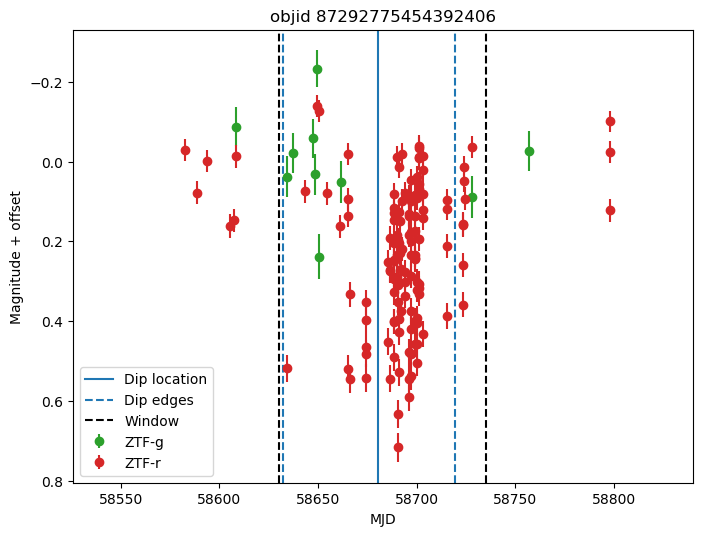

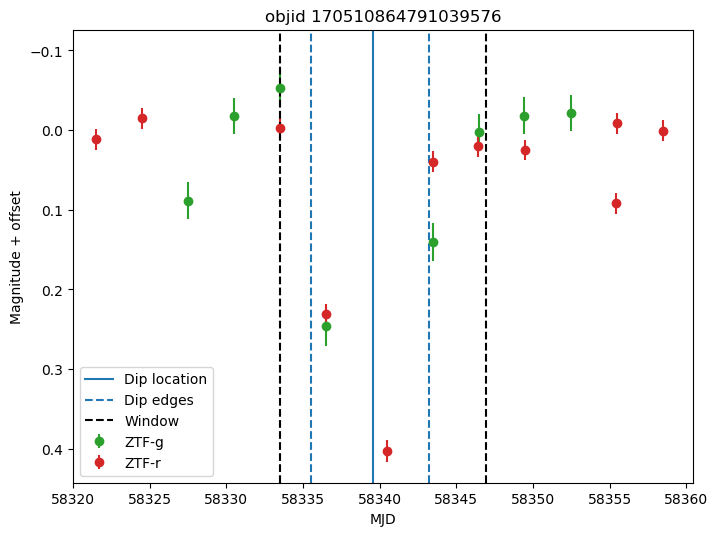

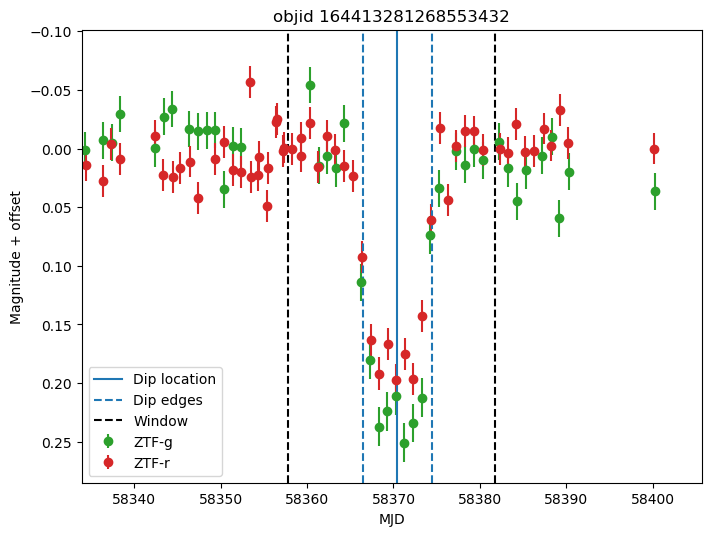

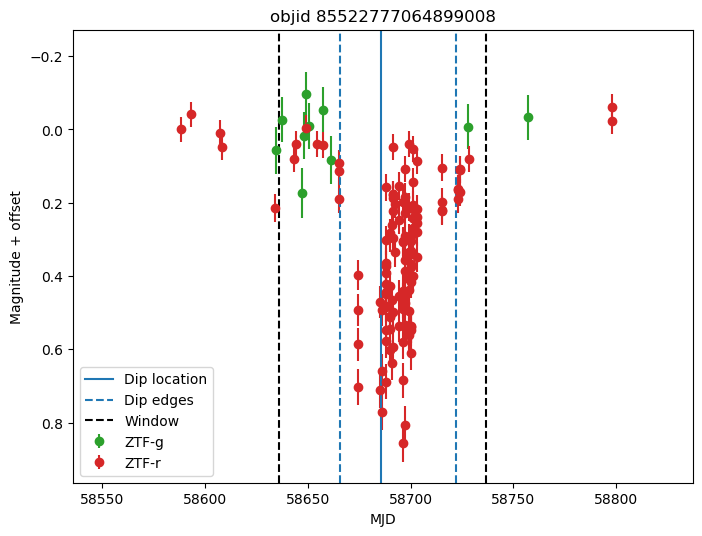

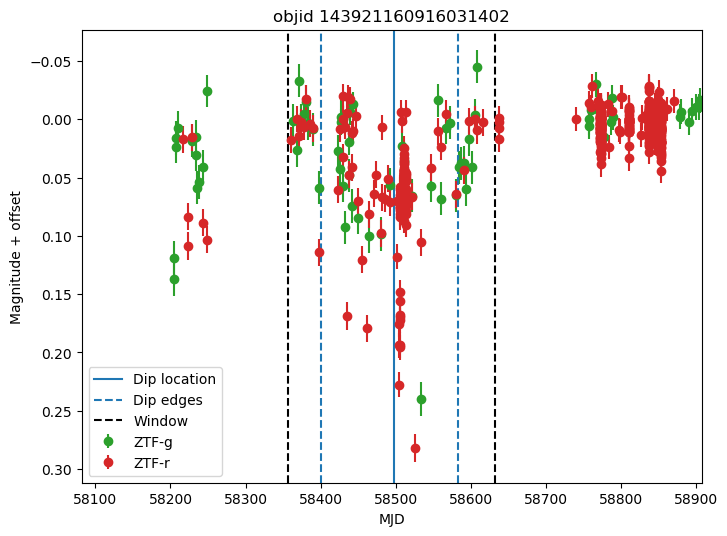

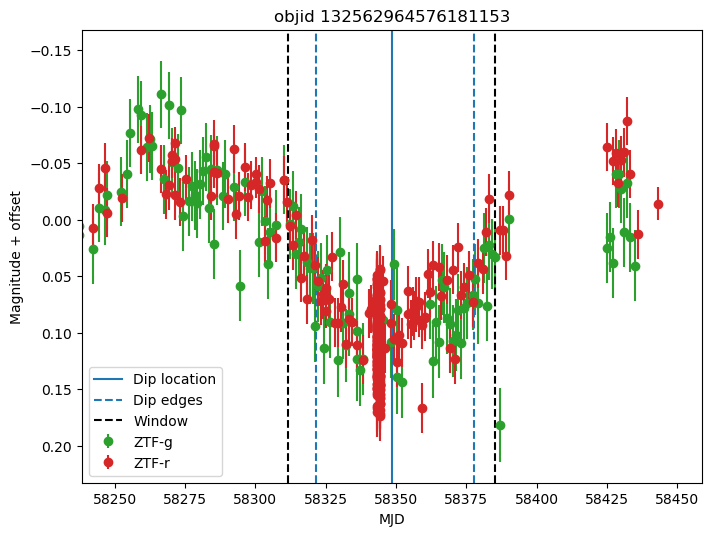

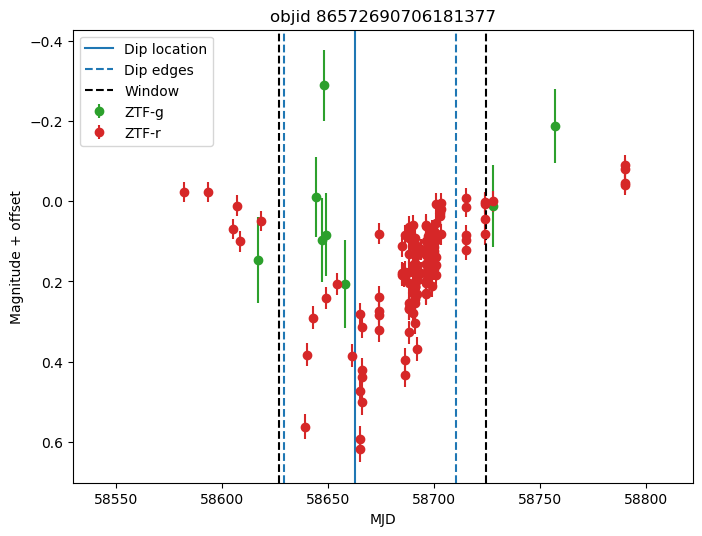

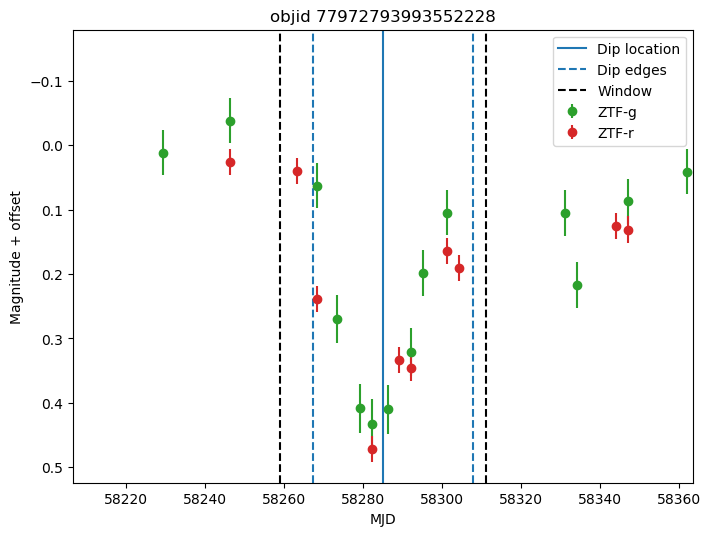

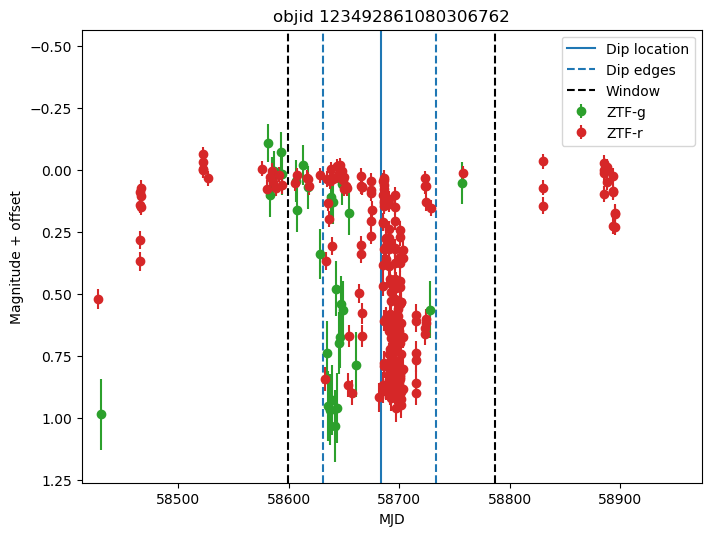

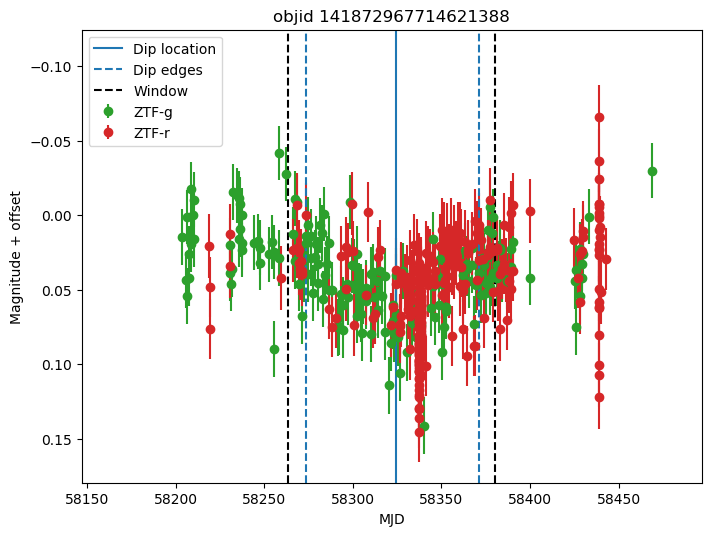

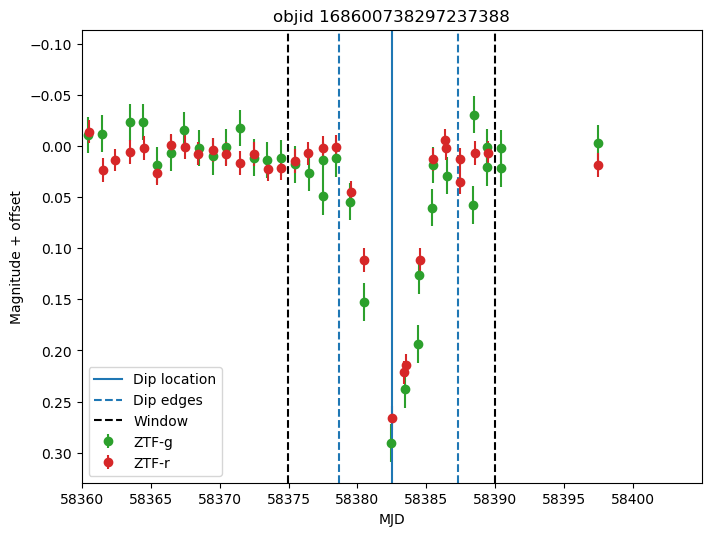

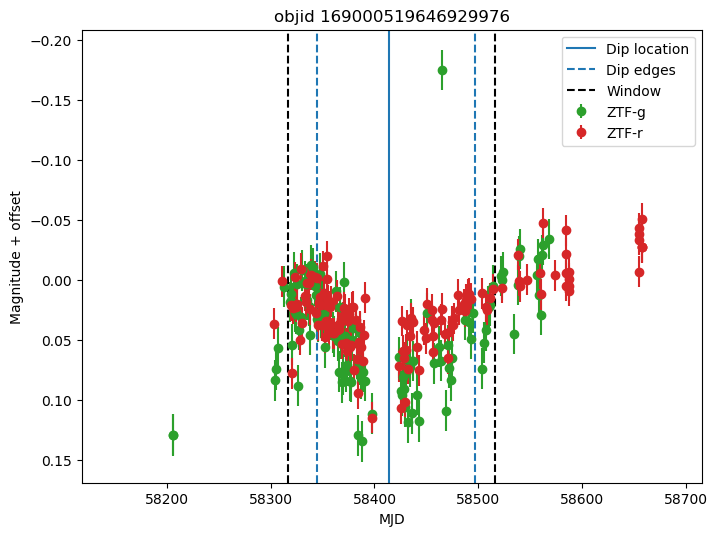

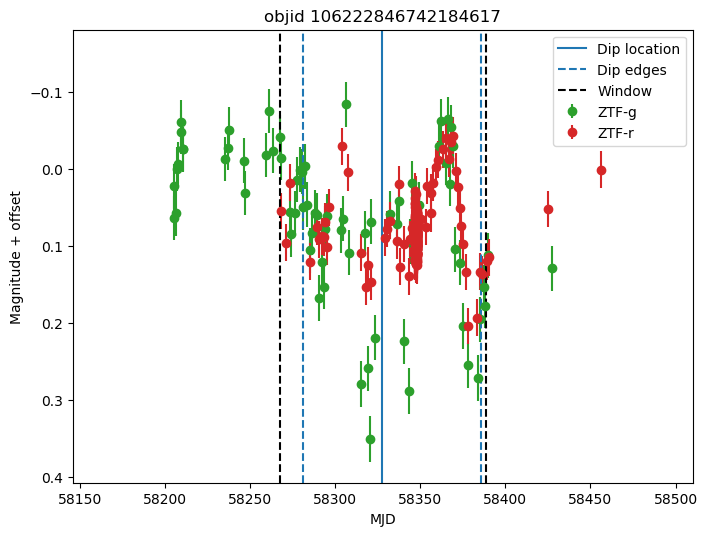

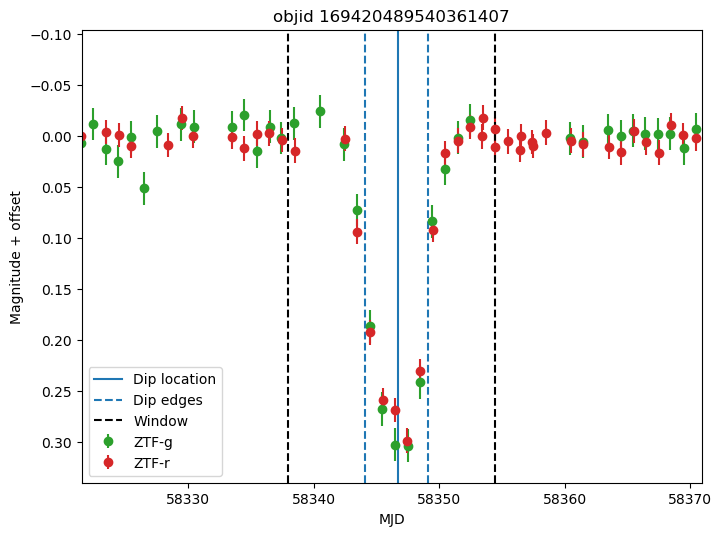

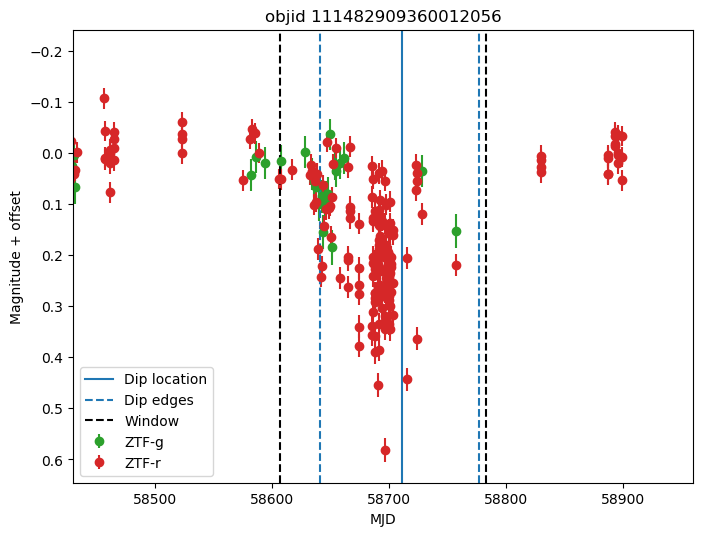

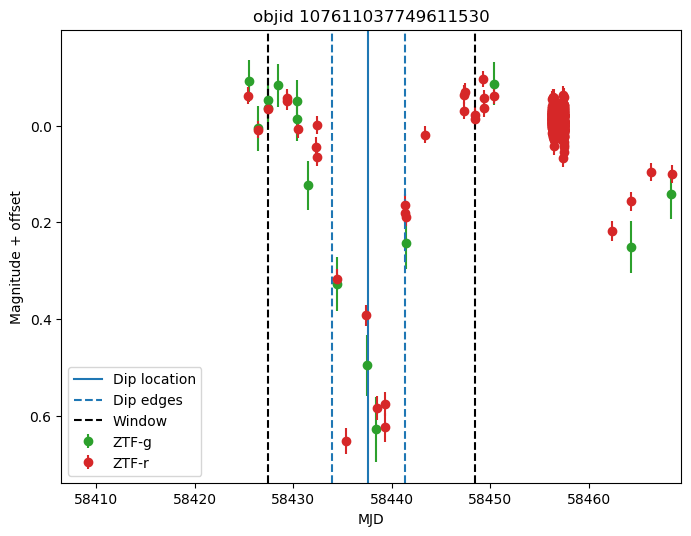

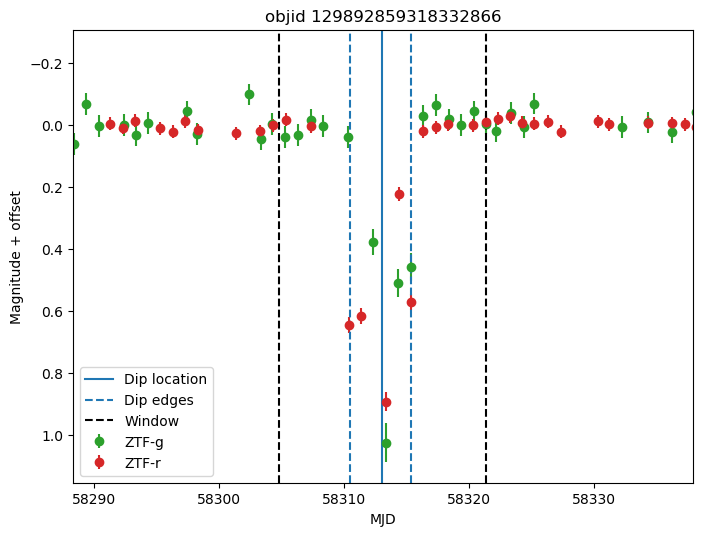

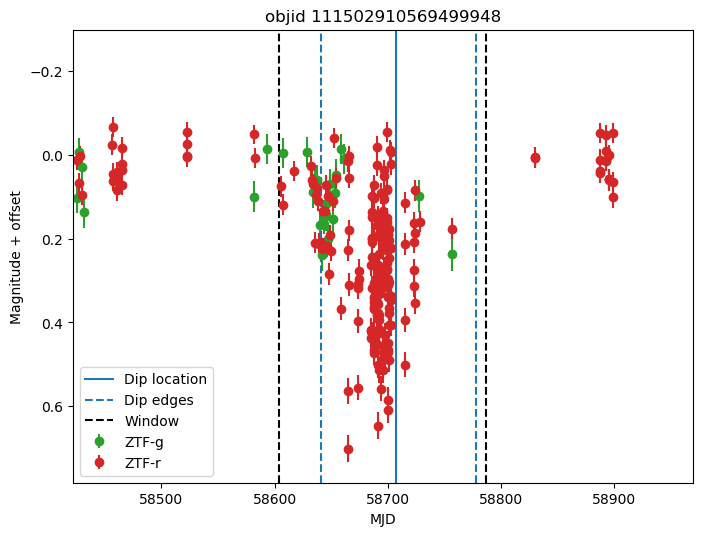

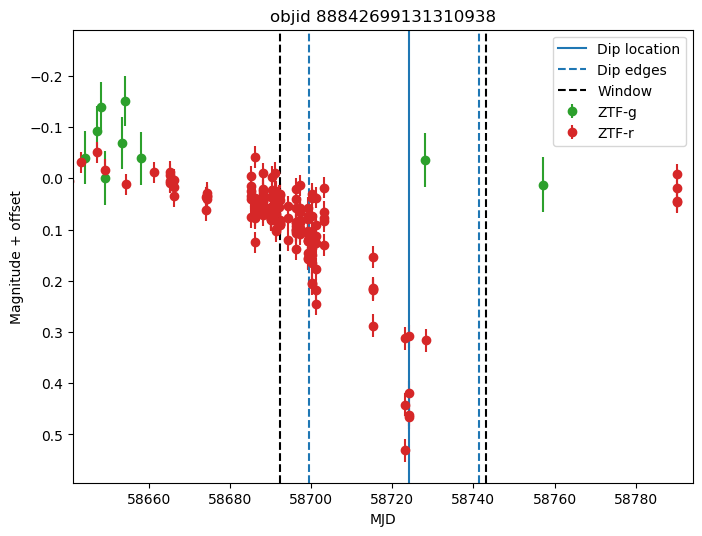

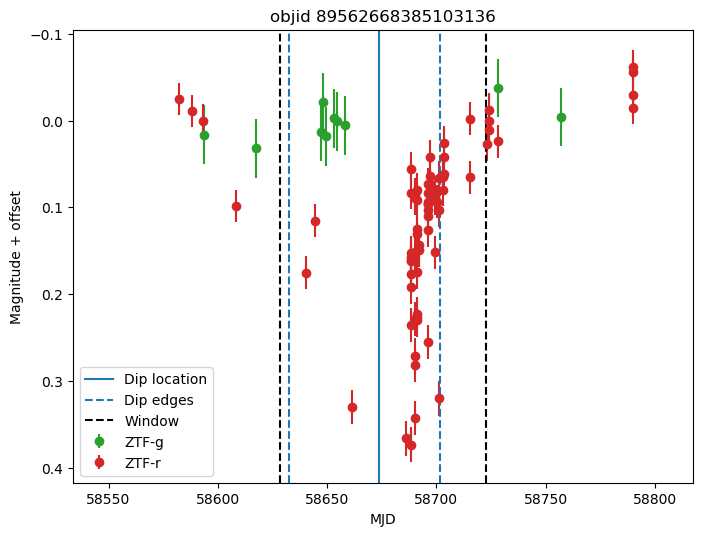

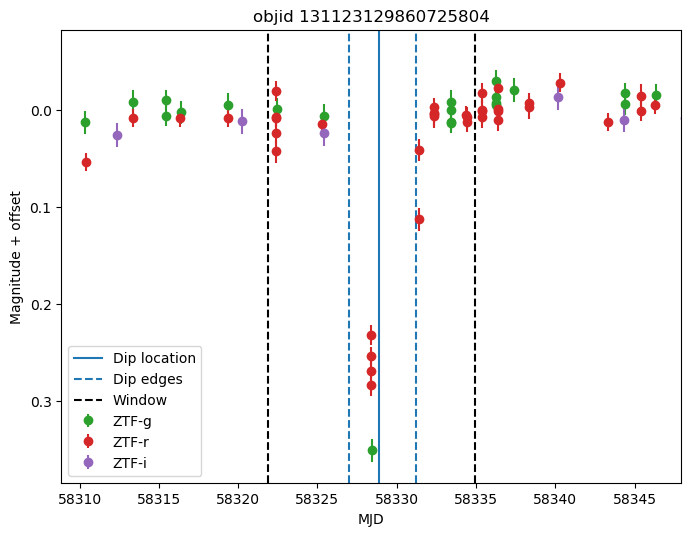

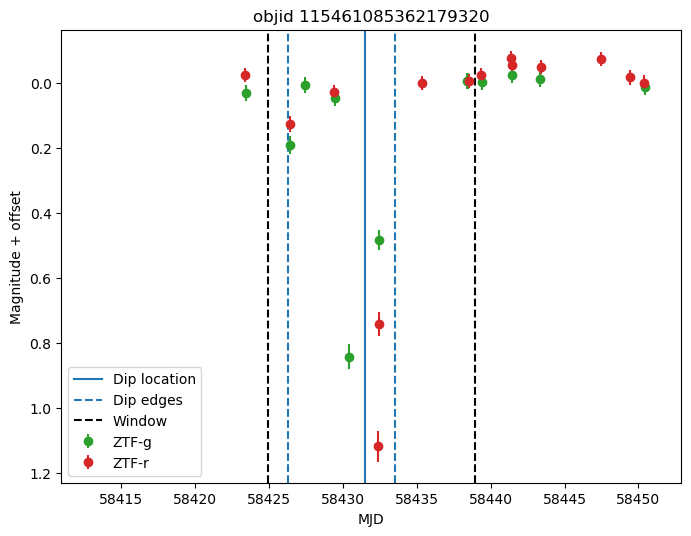

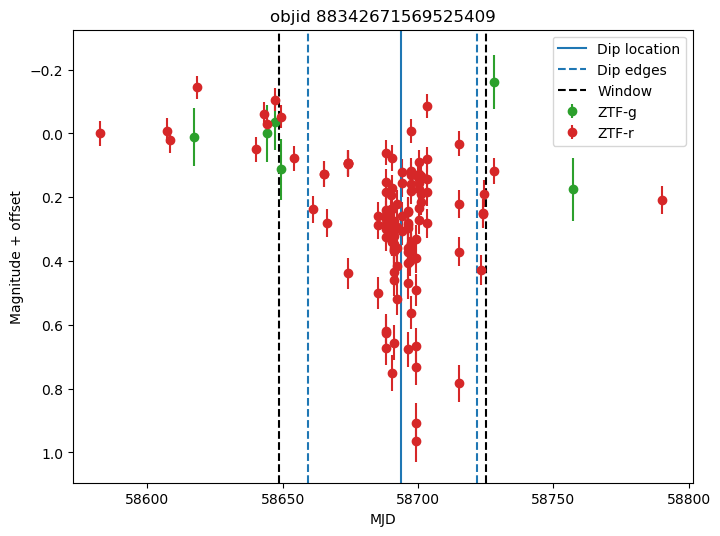

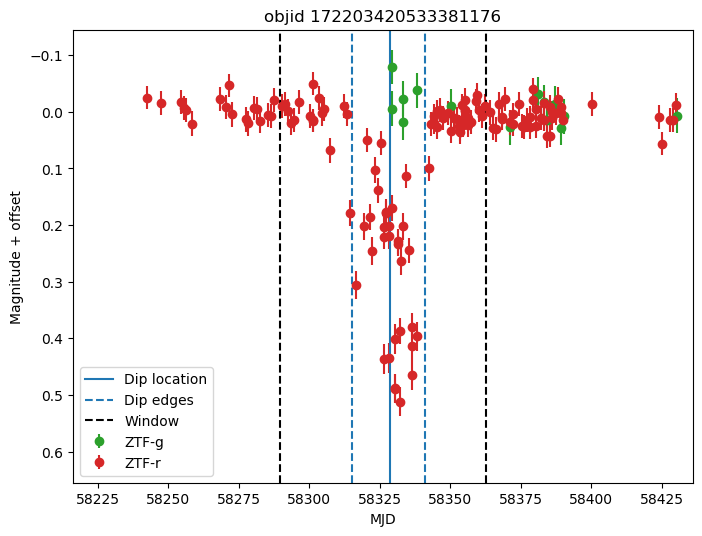

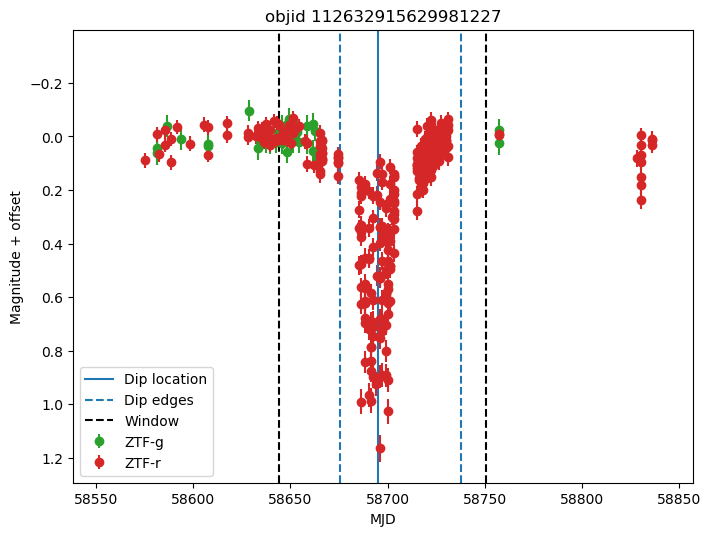

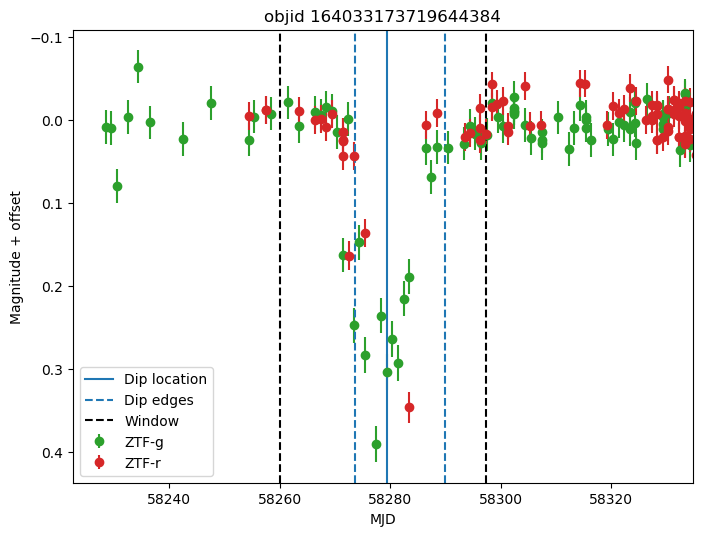

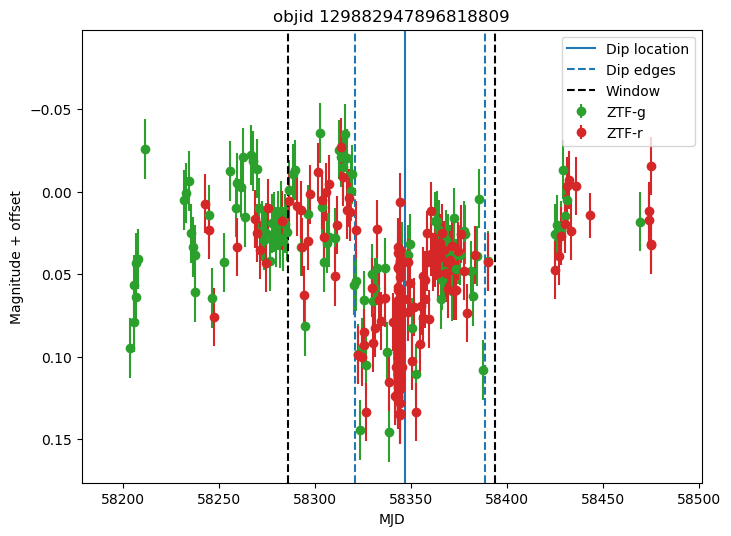

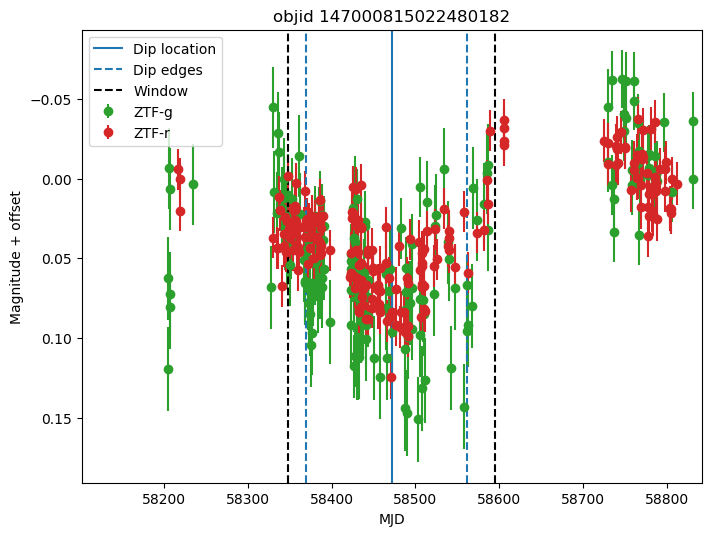

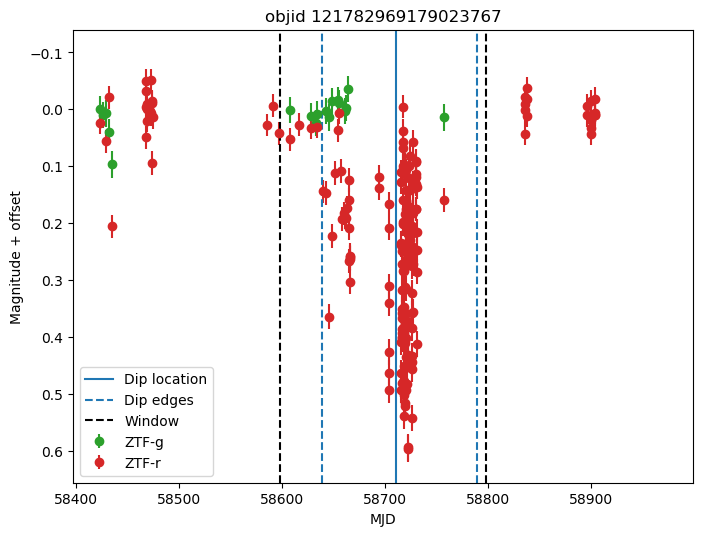

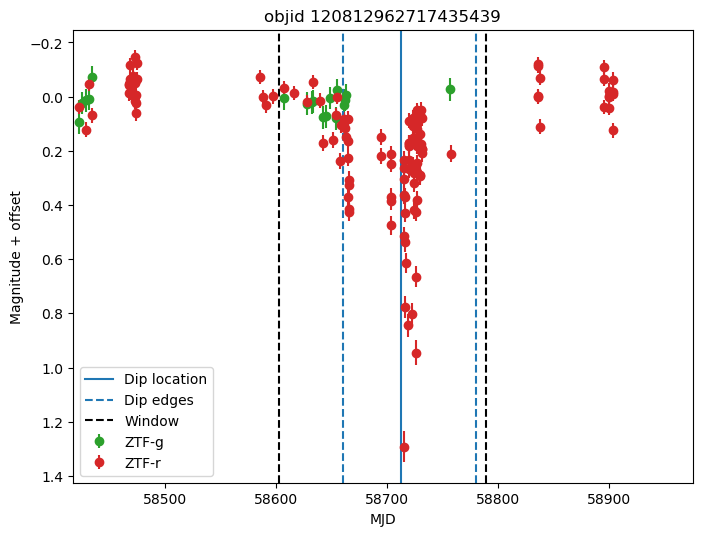

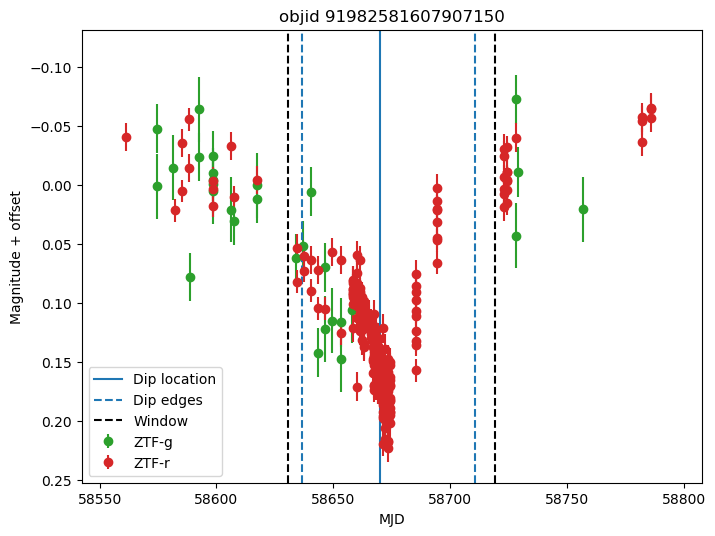

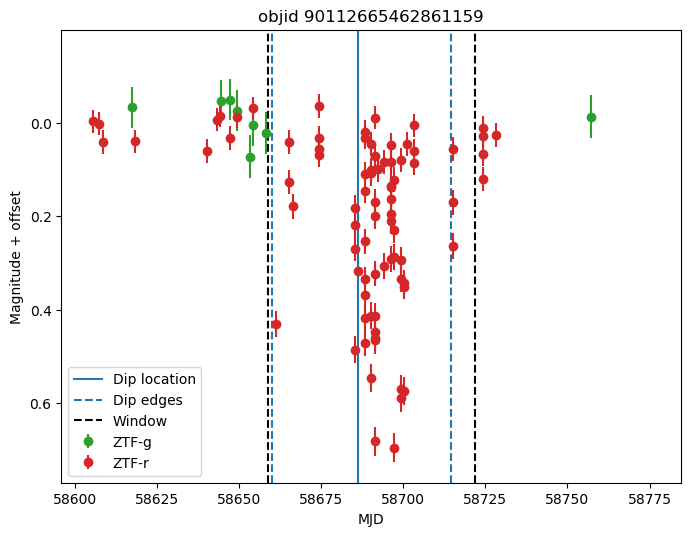

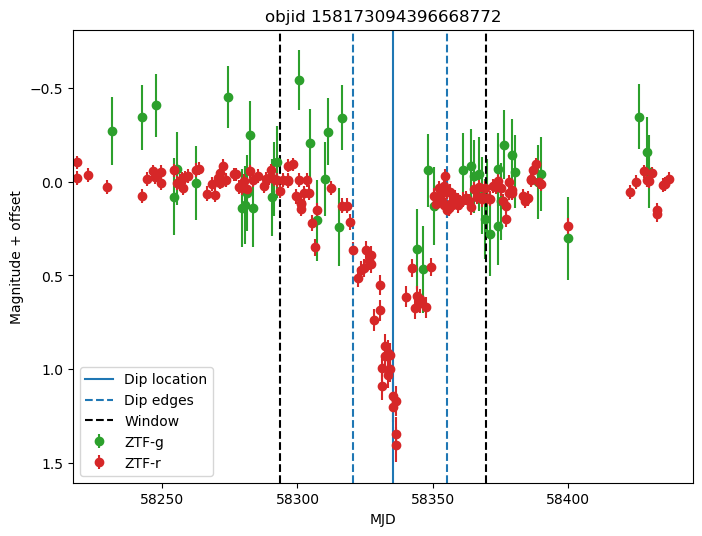

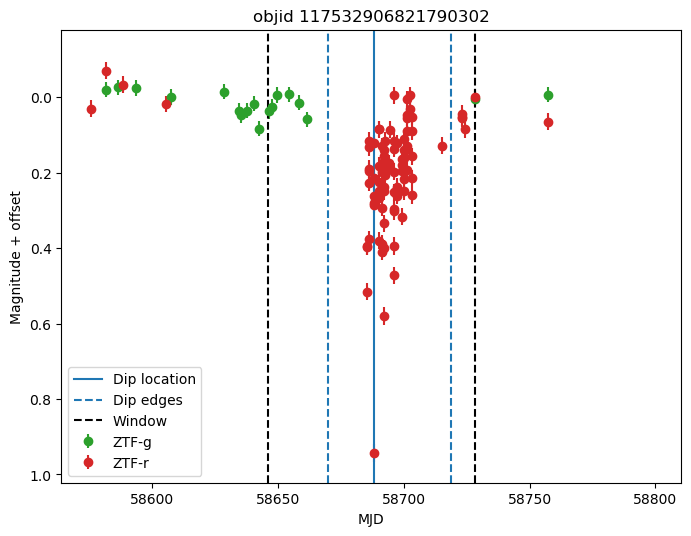

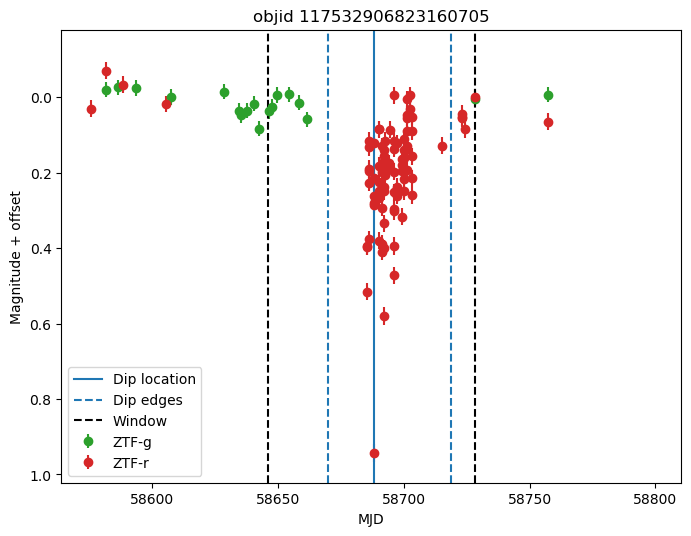

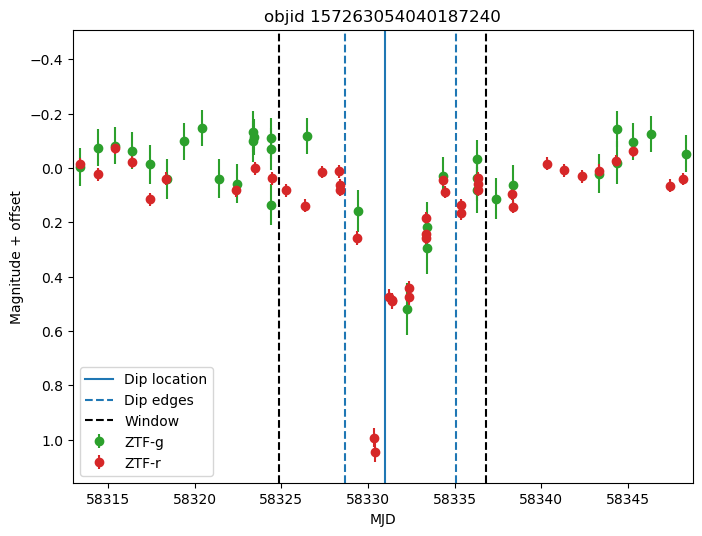

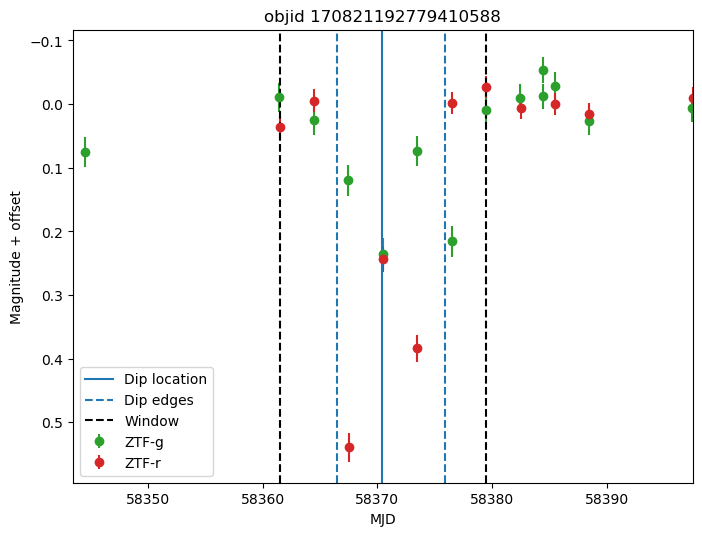

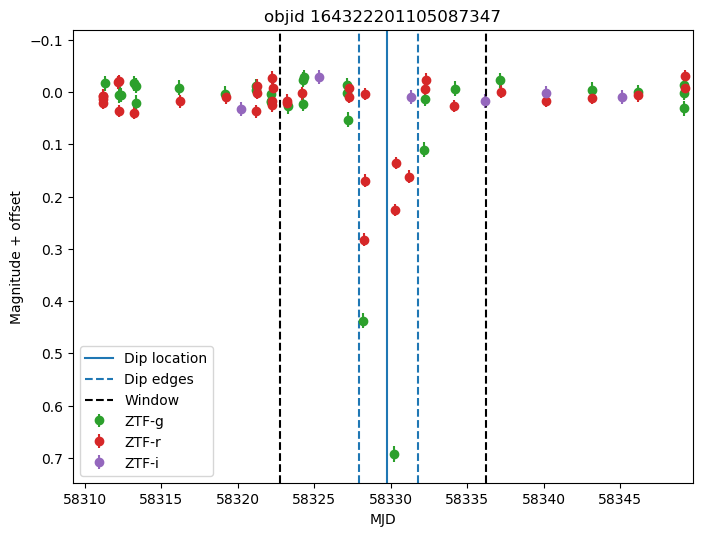

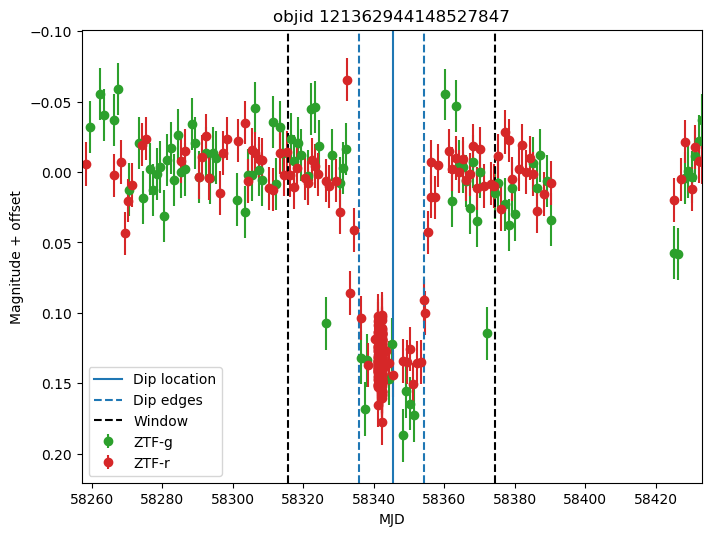

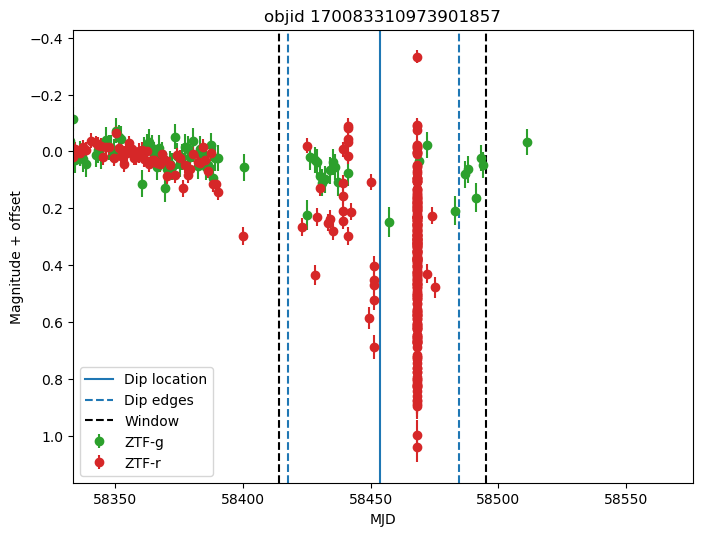

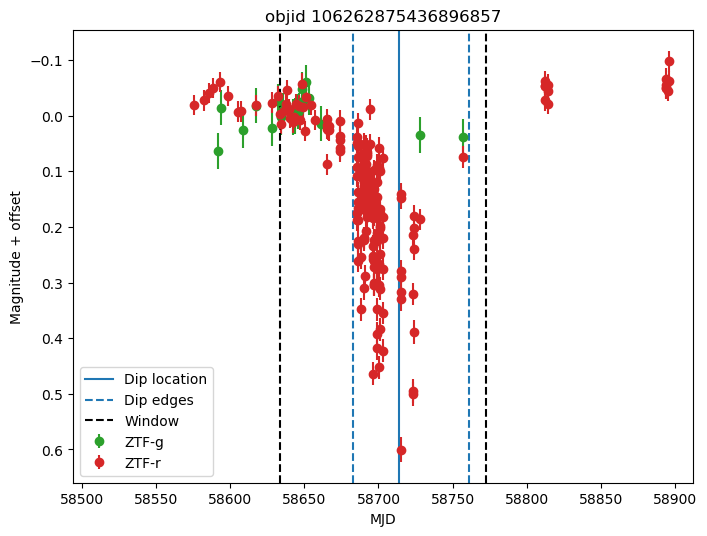

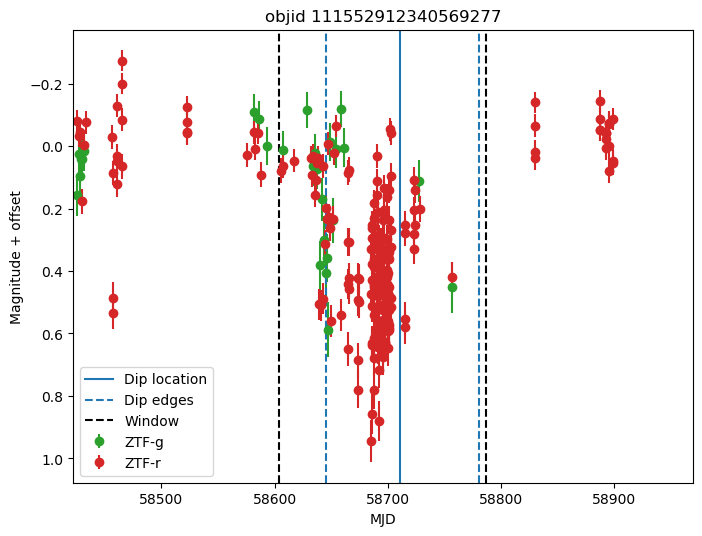

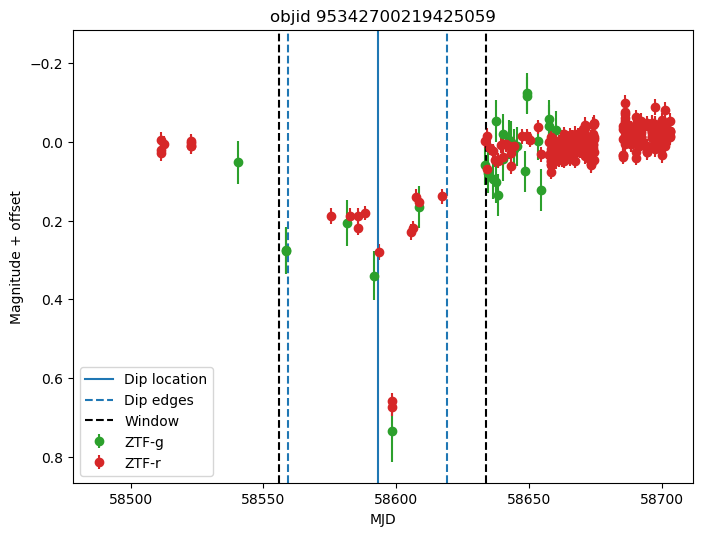

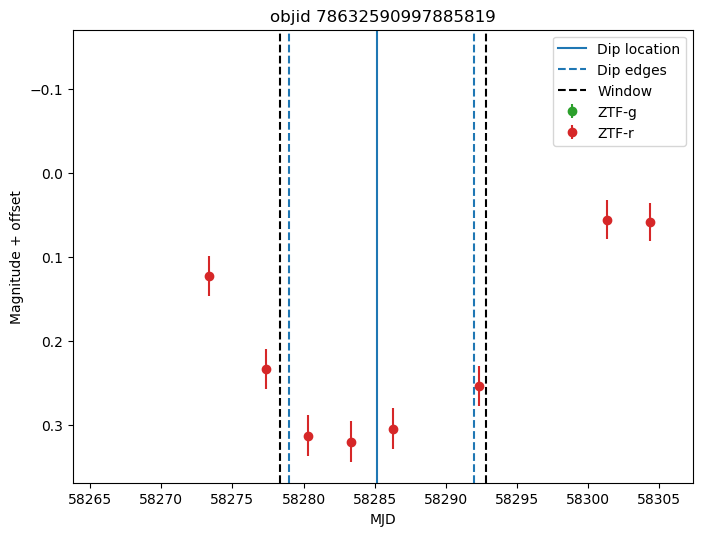

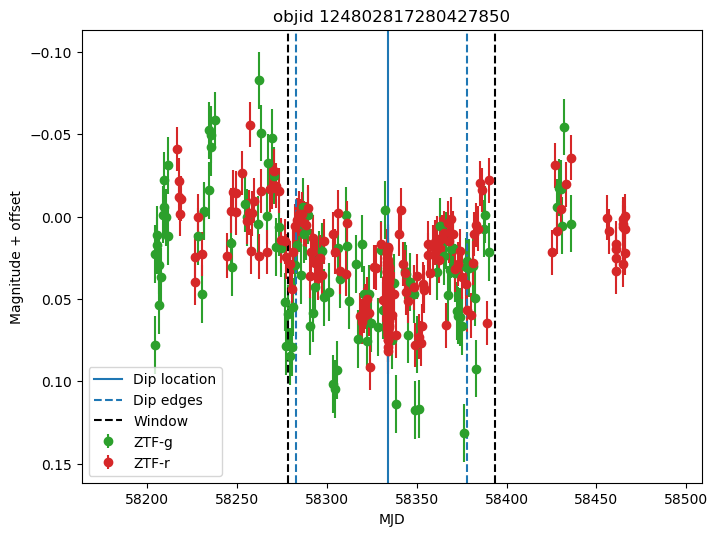

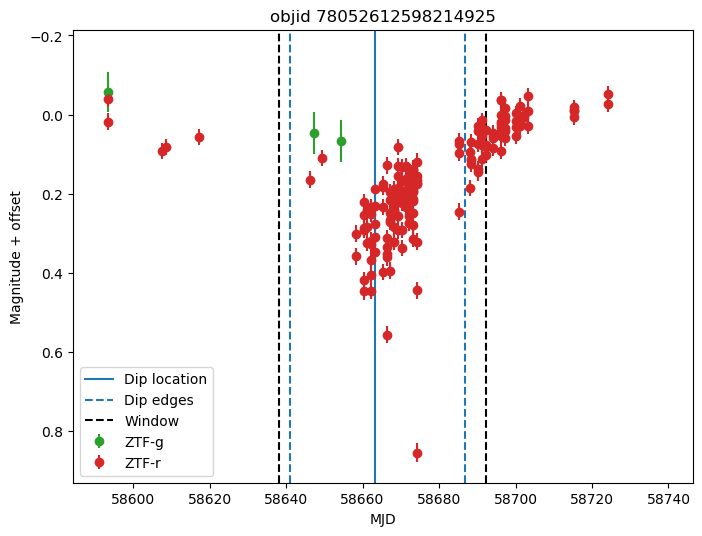

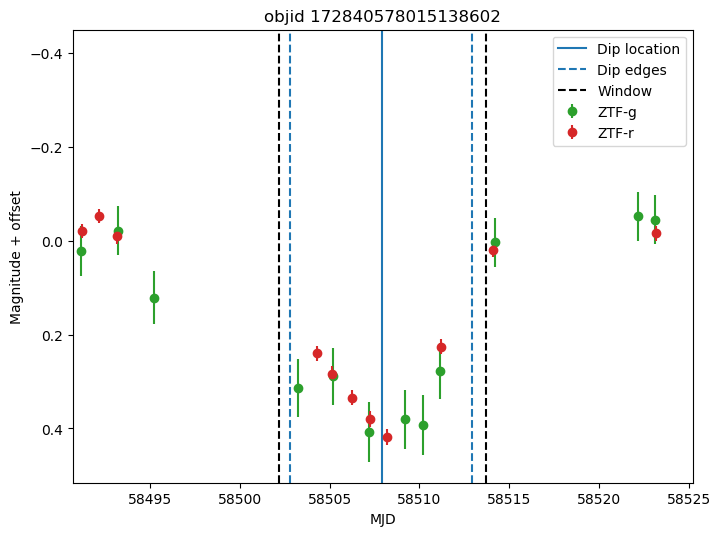

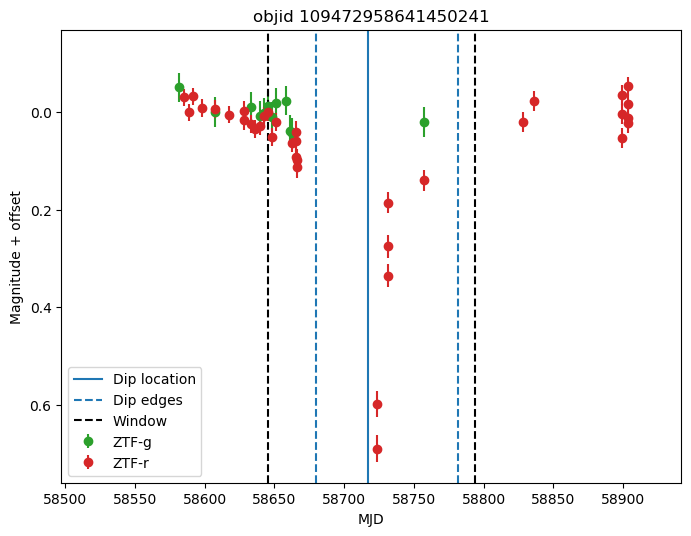

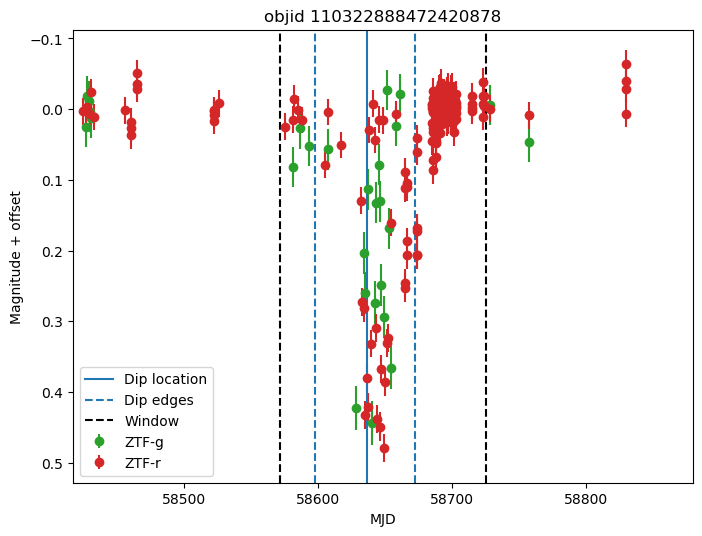

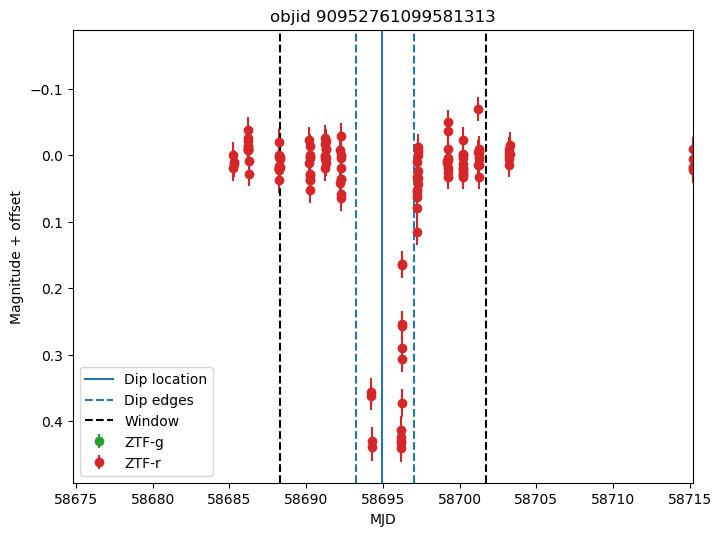

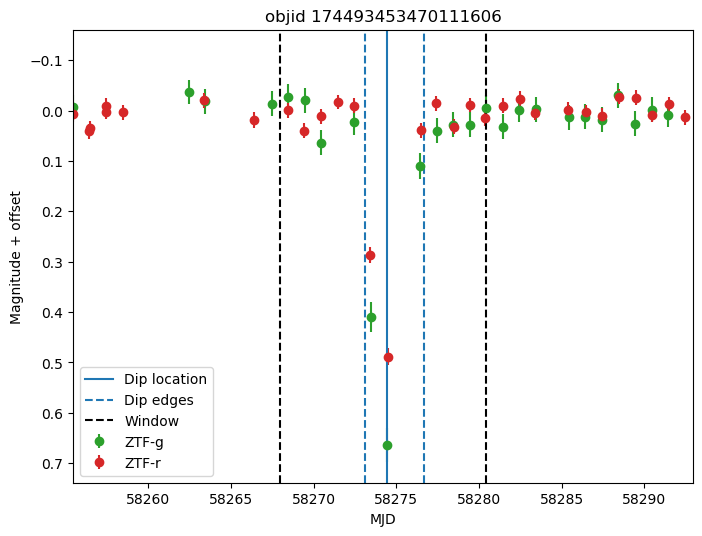

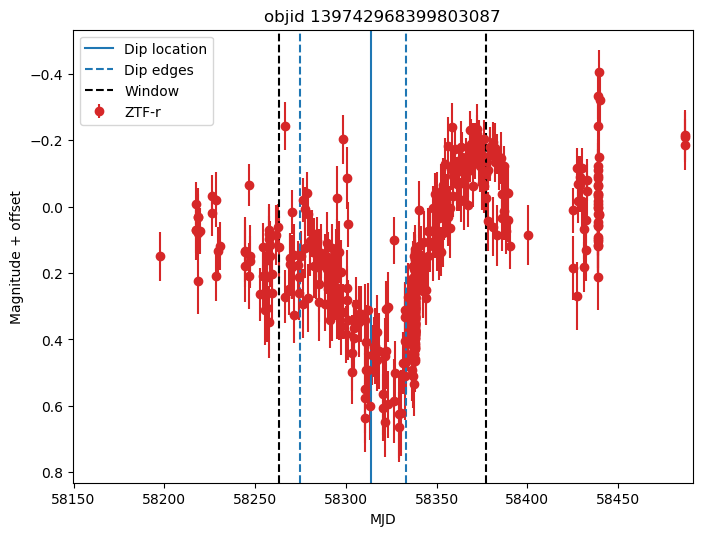

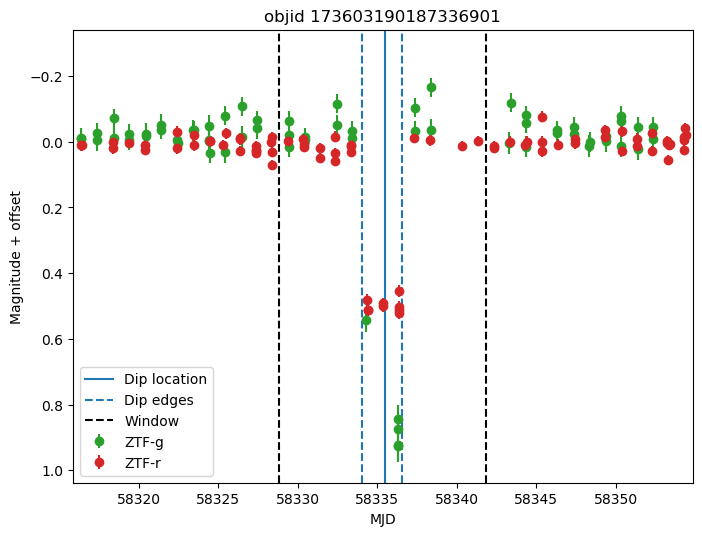

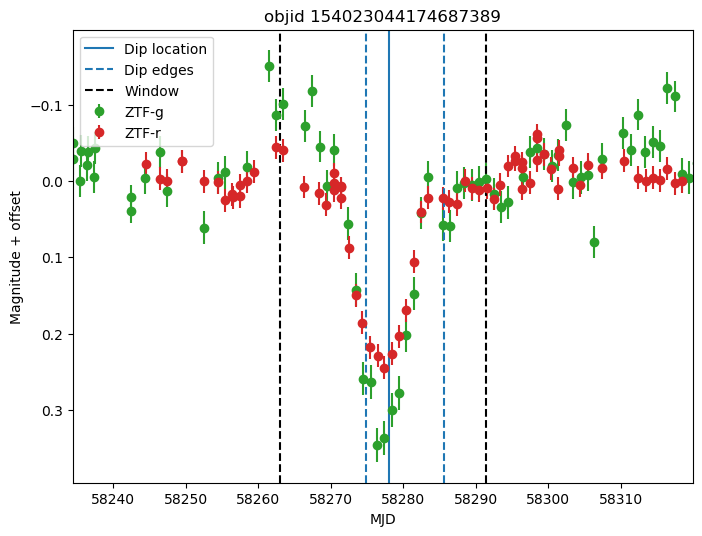

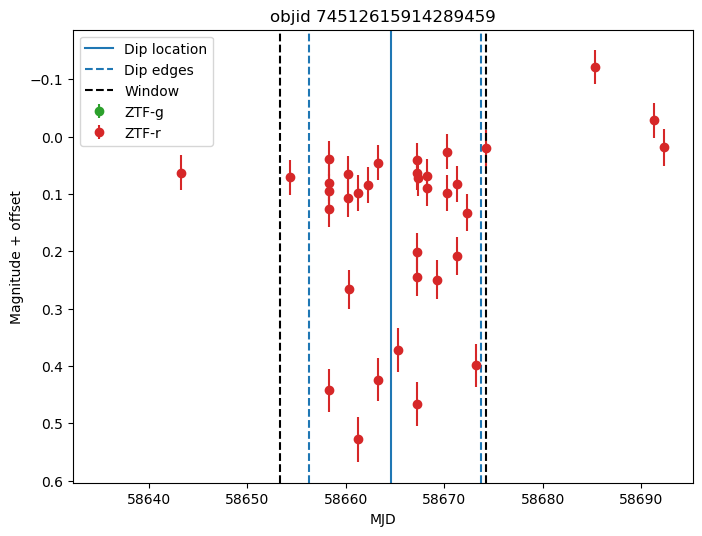

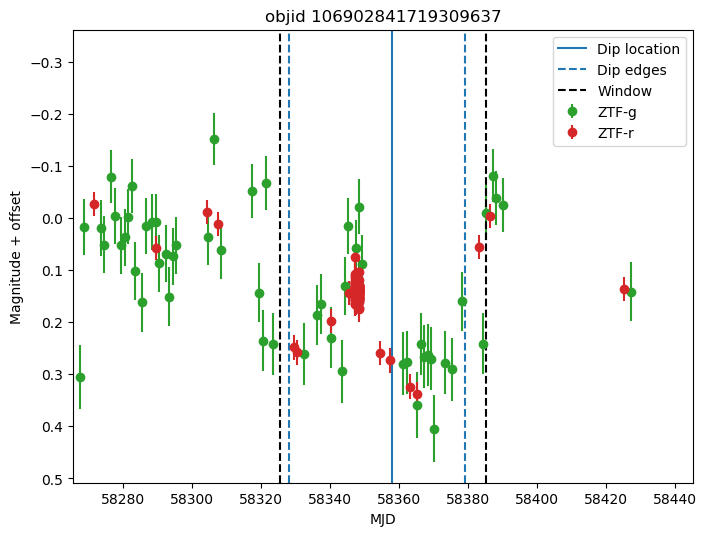

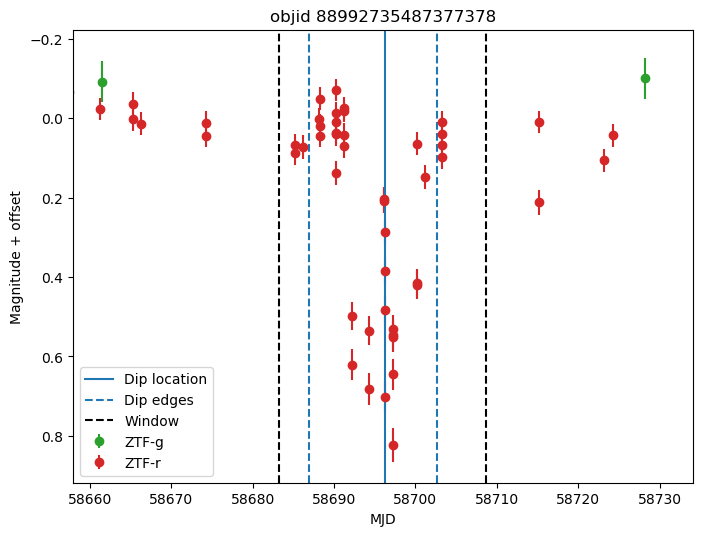

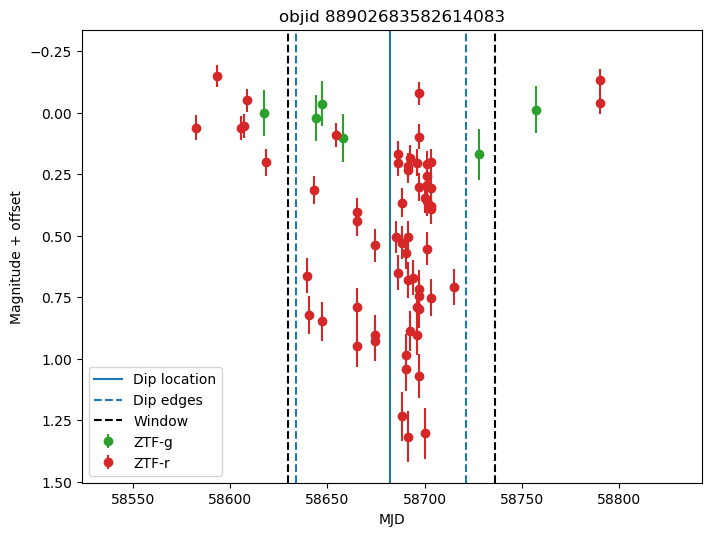

In [15]:
for i in range(100):
    dipper.plot_light_curve(best_dippers[i], zoom=True, verbose=False)